In [118]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [120]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission
from zipline.finance import slippage
from zipline.finance.slippage import SlippageModel

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [121]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

In [122]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [123]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

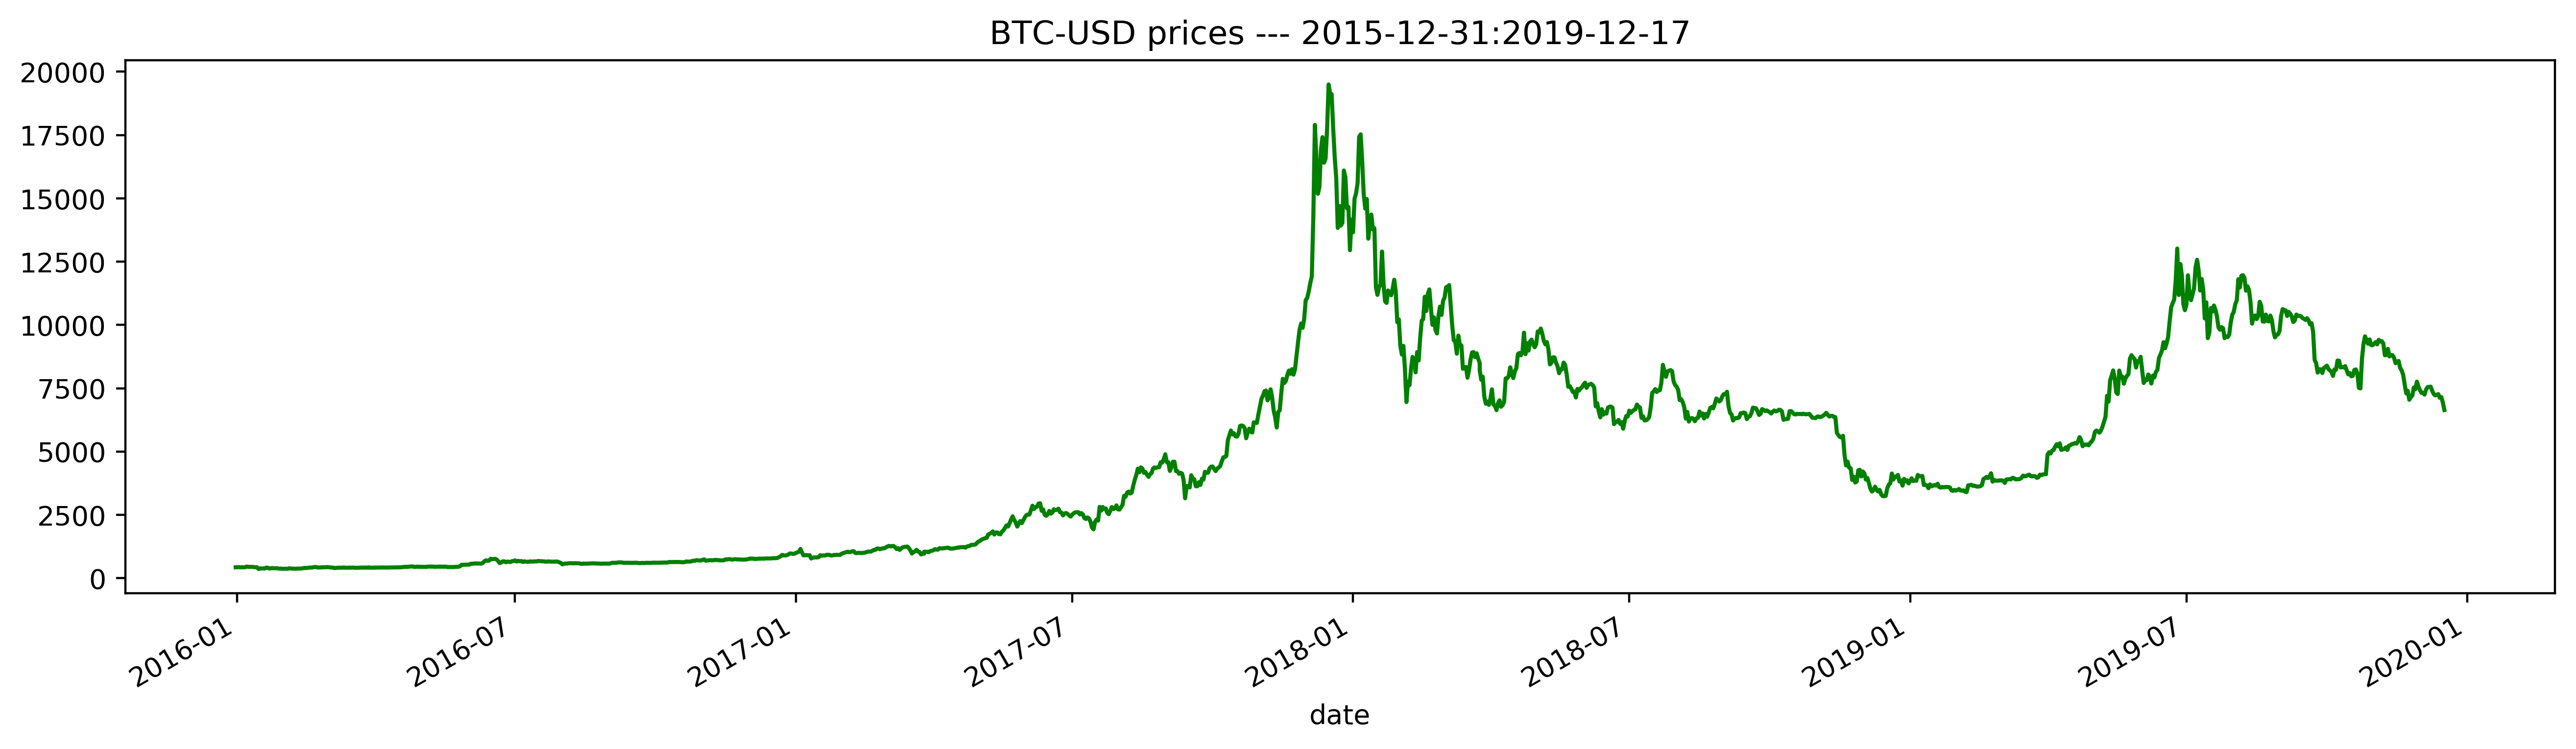

In [5]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-17', 
                  freq='daily', 
                  path='data/BTC.csv')

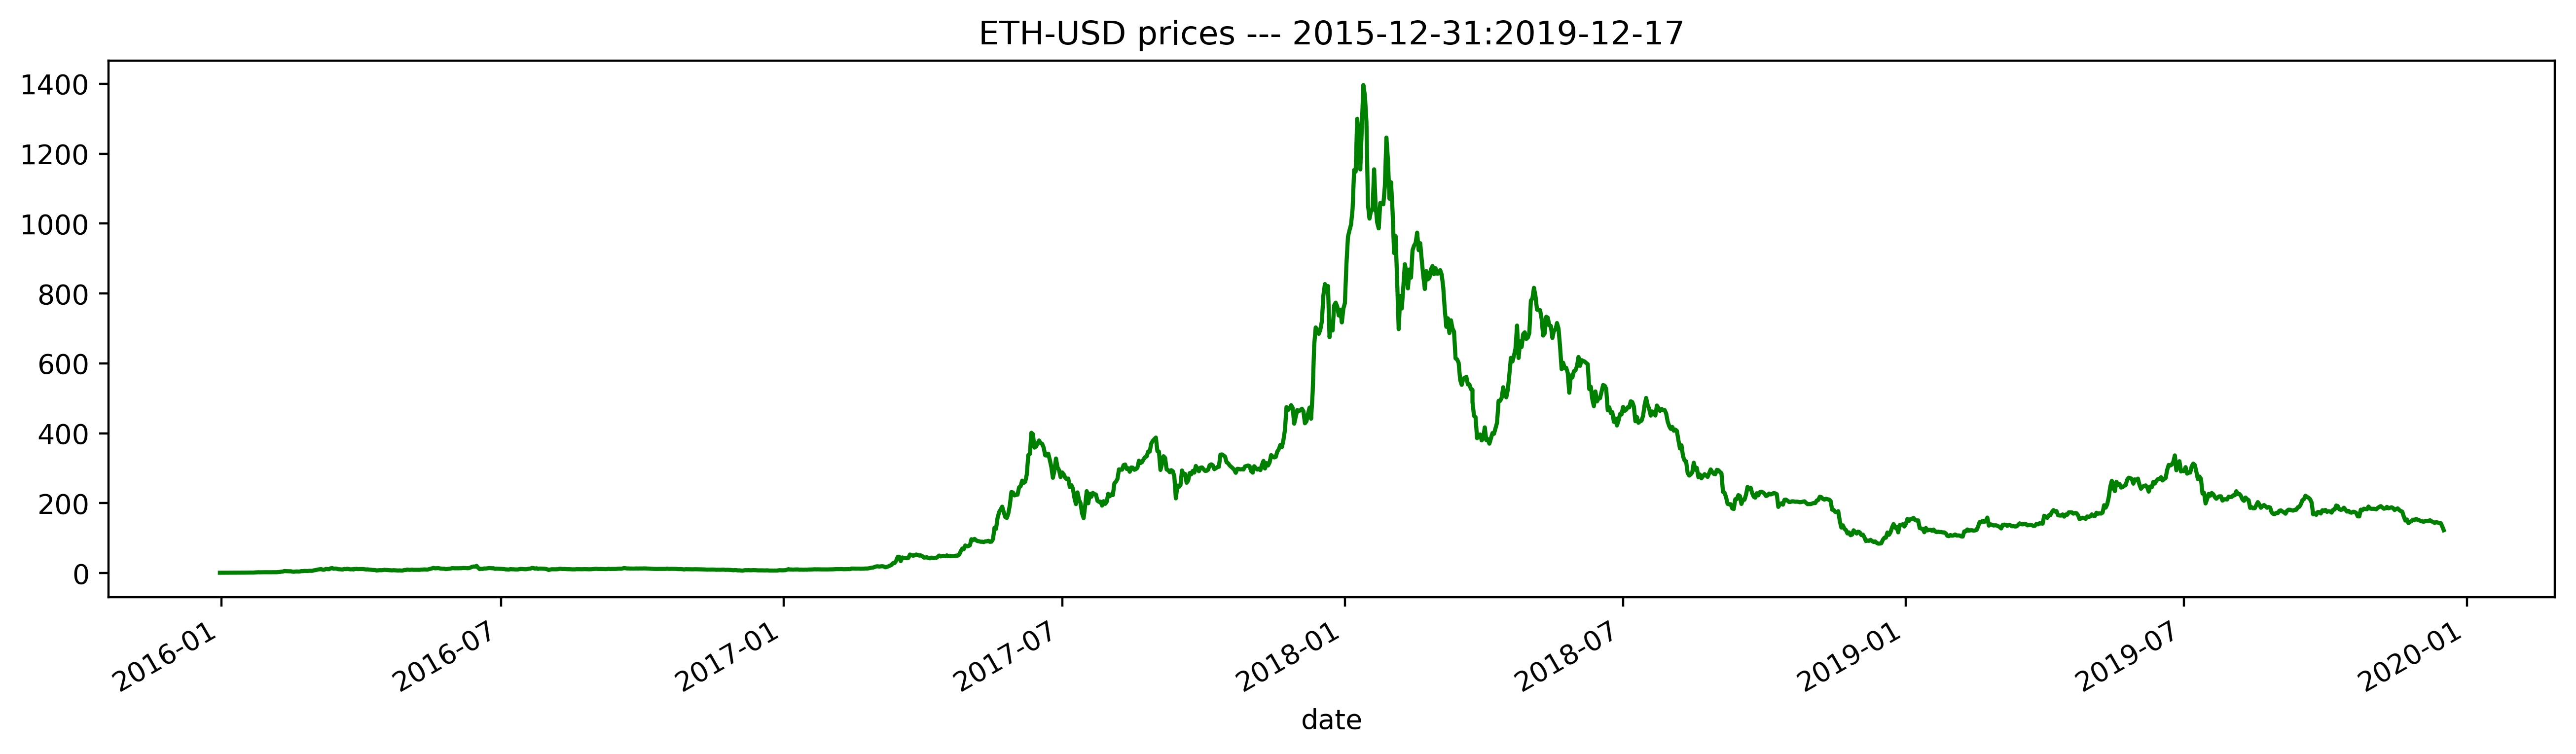

In [6]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-17', 
                  freq='daily', 
                  path='data/ETH.csv')

In [65]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'high', 'low', 'close']

In [66]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].tail())

                   open         high          low        close
date                                                          
2019-12-13  7244.662109  7293.560547  7227.122559  7269.684570
2019-12-14  7268.902832  7308.836426  7097.208984  7124.673828
2019-12-15  7124.239746  7181.075684  6924.375977  7152.301758
2019-12-16  7153.663086  7171.168945  6903.682617  6932.480469
2019-12-17  6931.315430  6964.075195  6587.974121  6640.515137
                  open        high         low       close
date                                                      
2019-12-13  145.655685  145.857101  143.746521  144.944748
2019-12-14  144.953415  145.529083  142.434555  142.869232
2019-12-15  142.864990  143.925354  139.426956  143.114990
2019-12-16  143.139526  143.224854  132.456665  133.614029
2019-12-17  133.647186  134.011536  121.395081  122.603889


In [67]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1448 (major_axis) x 4 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-17 00:00:00+00:00
Minor_axis axis: open to close


In [68]:
WEIGHTS = [[0.8, 0], [0.55, 0.25]]
ASSETS_START = [date(2017, 1, 2)]
COMMISSION = 0.0007

In [69]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('BTC'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.stage = 0
    
    context.assets_start = ASSETS_START
    
    context.rebalance_period = 90
    context.time = 0

In [70]:
def asset_chek(context, day, n):
    
    # Проверка начала закупки
    if day == context.assets_start[n]:
        context.stage = n + 1
        context.time = 0

In [71]:
def start_buying_check(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    day = prices.index[0].date()
    
    for i in range(0, context.n_assets - 1):
        asset_chek(context, day, i) 

In [72]:
def handle_data(context, data):
    
    start_buying_check(context, data)
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[context.stage][i])
            
    
    context.time += 1

In [73]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 17, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              #trading_calendar=AlwaysOpenCalendar(),
                              handle_data=handle_data,
                              data=panel)

In [74]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

# Создание отчета стратегии

In [75]:
#pf.plot_drawdown_periods(returns, top=5)
#plt.show()

In [76]:
#pf.create_simple_tear_sheet(returns)

In [77]:
qf.get_performance_summary(returns)

annual_volatility      0.620752
annualized_returns     0.851663
cumulative_returns    10.499843
max_drawdown          -0.759519
sharpe_ratio           1.302565
sortino_ratio          1.987937
dtype: float64

In [78]:
#pf.create_simple_tear_sheet(returns, positions, transactions, live_start_date='2017-01-01')

In [79]:
#pf.create_full_tear_sheet(returns)

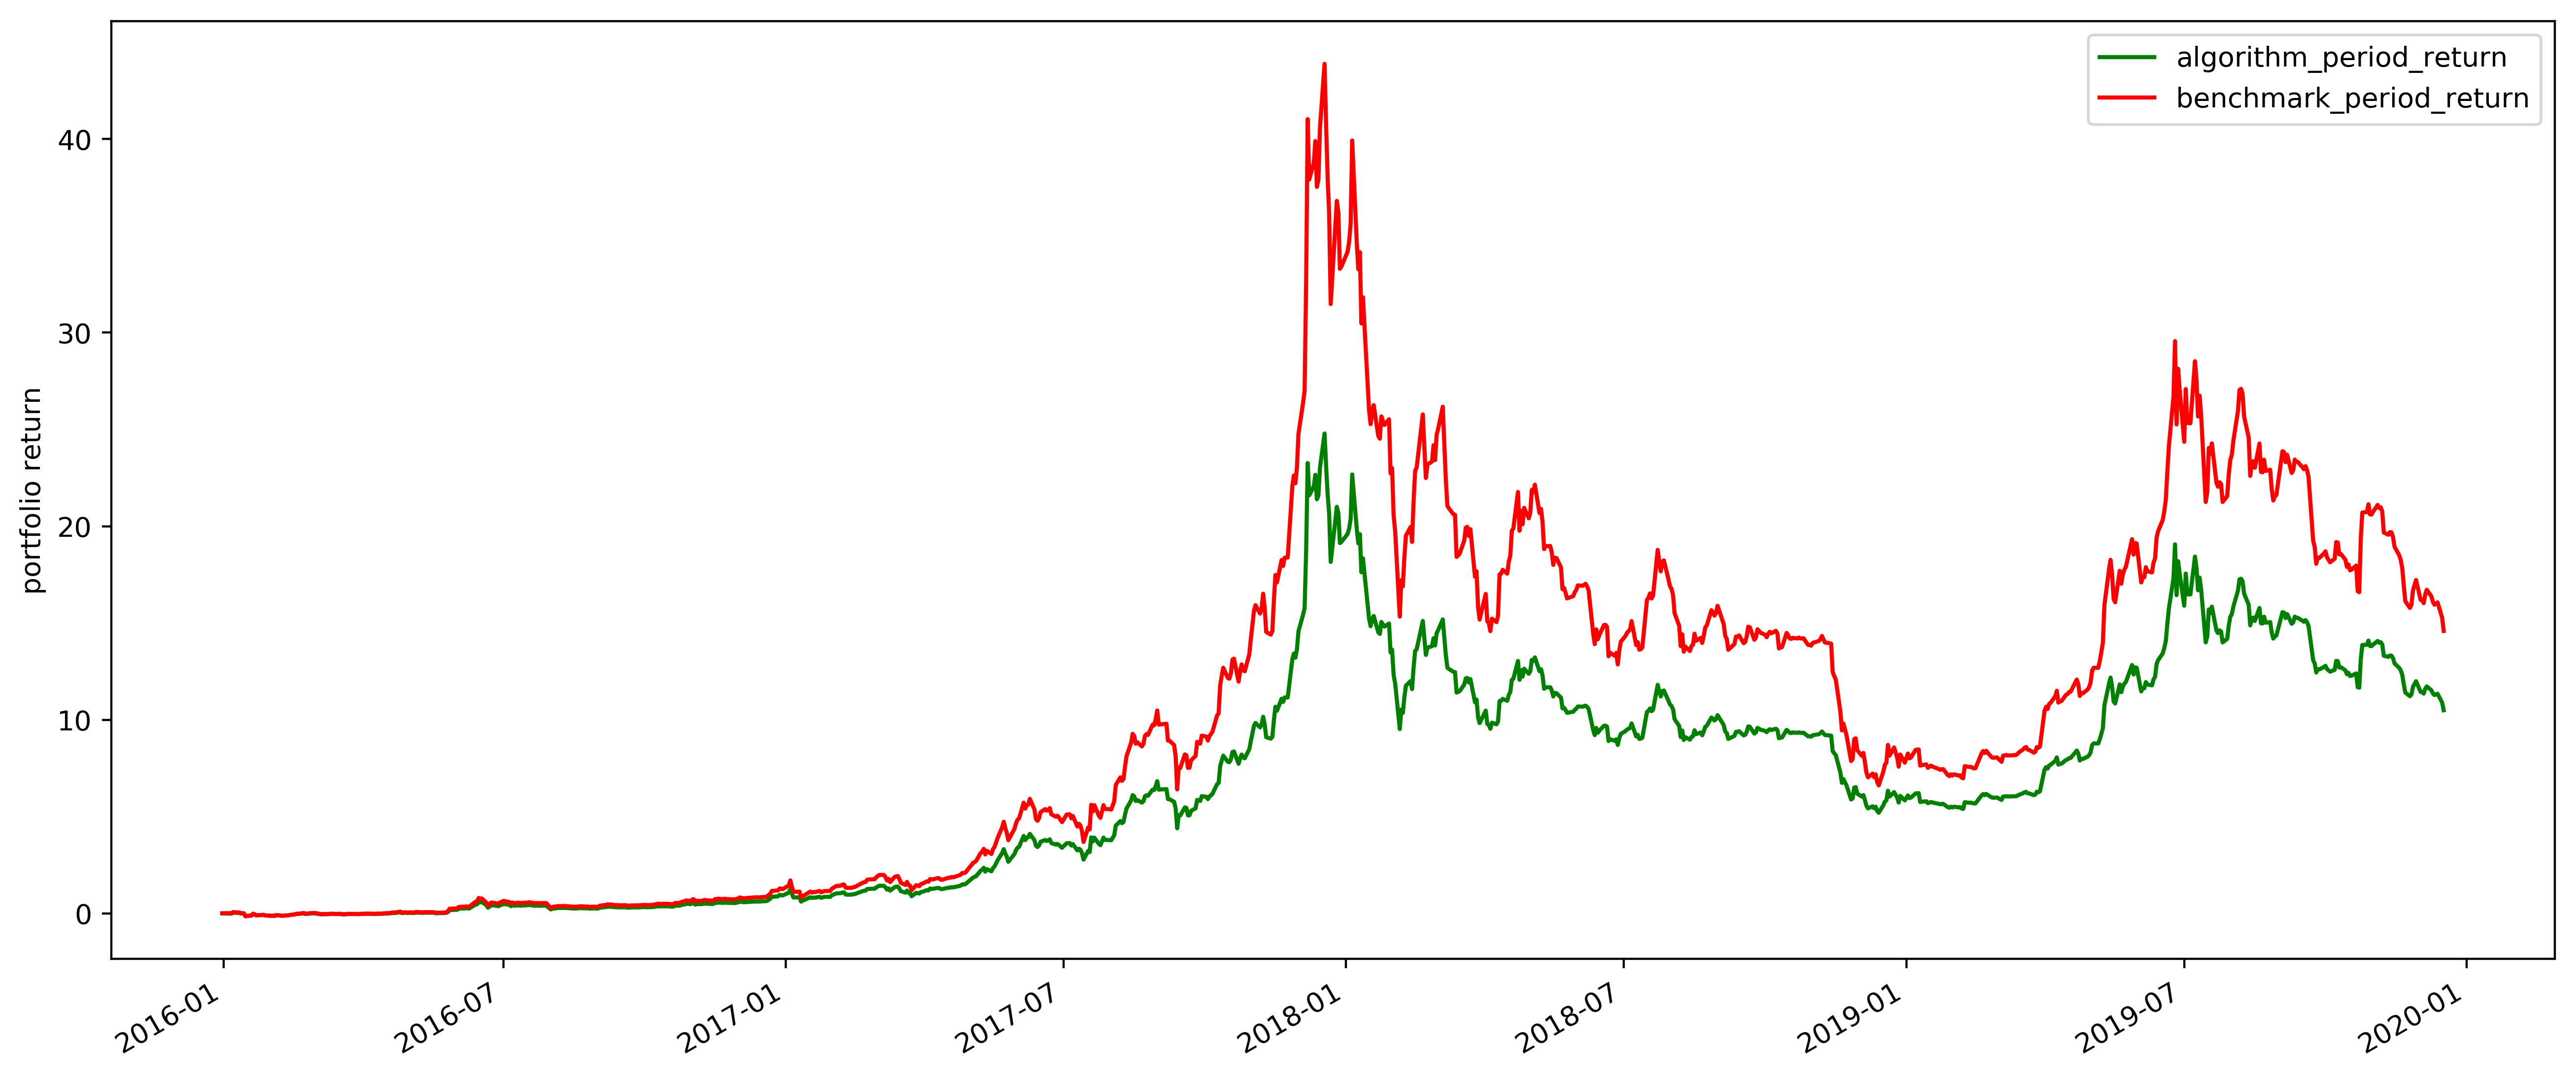

Final portfolio return: 1049.98%
Final benchmark return: 1459.26%


In [80]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [81]:
paradigm = perf.portfolio_value
paradigm = paradigm / 100000

In [82]:
paradigm = paradigm.to_frame(name="close")

In [83]:
paradigm.tail()

close
2019-12-11 00:00:00+00:00  1228.075108
2019-12-12 00:00:00+00:00  1231.554811
2019-12-13 00:00:00+00:00  1235.148659
2019-12-16 00:00:00+00:00  1189.504712
2019-12-17 00:00:00+00:00  1149.984284

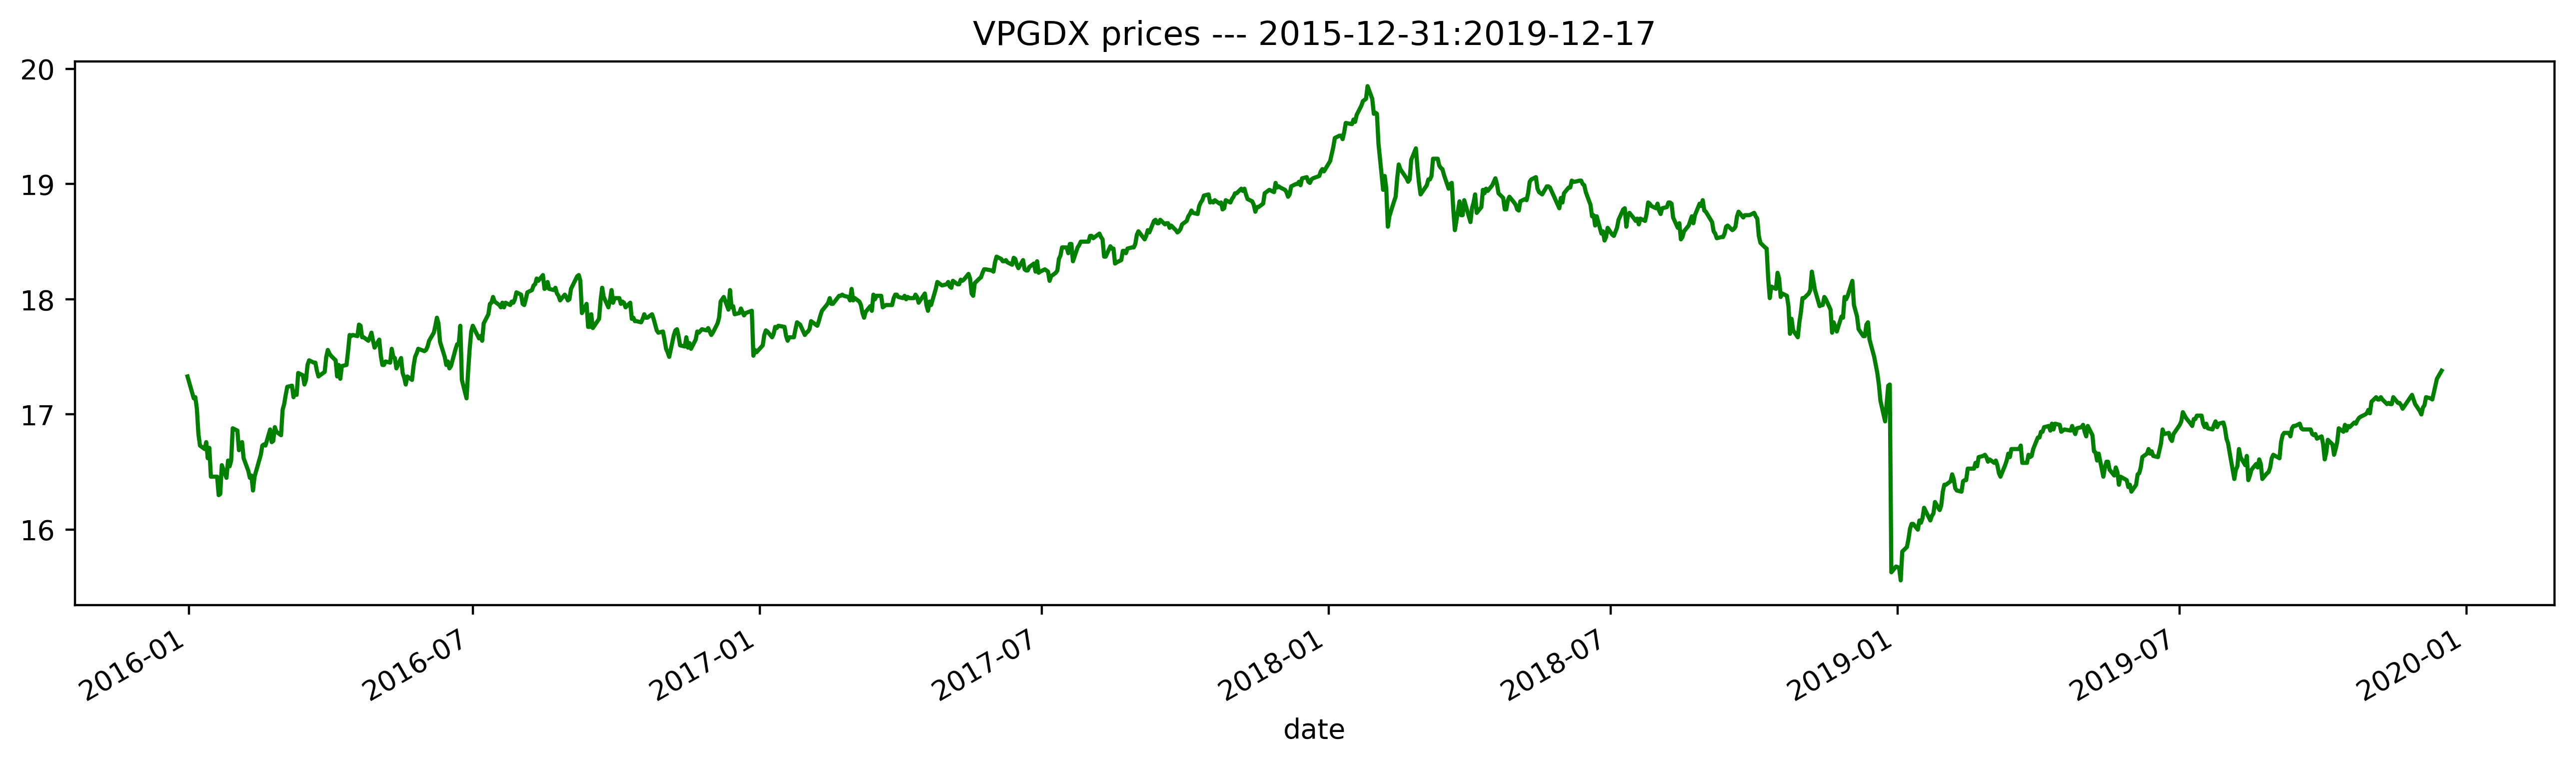

In [84]:
download_csv_data(ticker='VPGDX', 
                  start_date='2015-12-31', 
                  end_date='2019-12-17', 
                  freq='daily', 
                  path='data/VPGDX.csv')

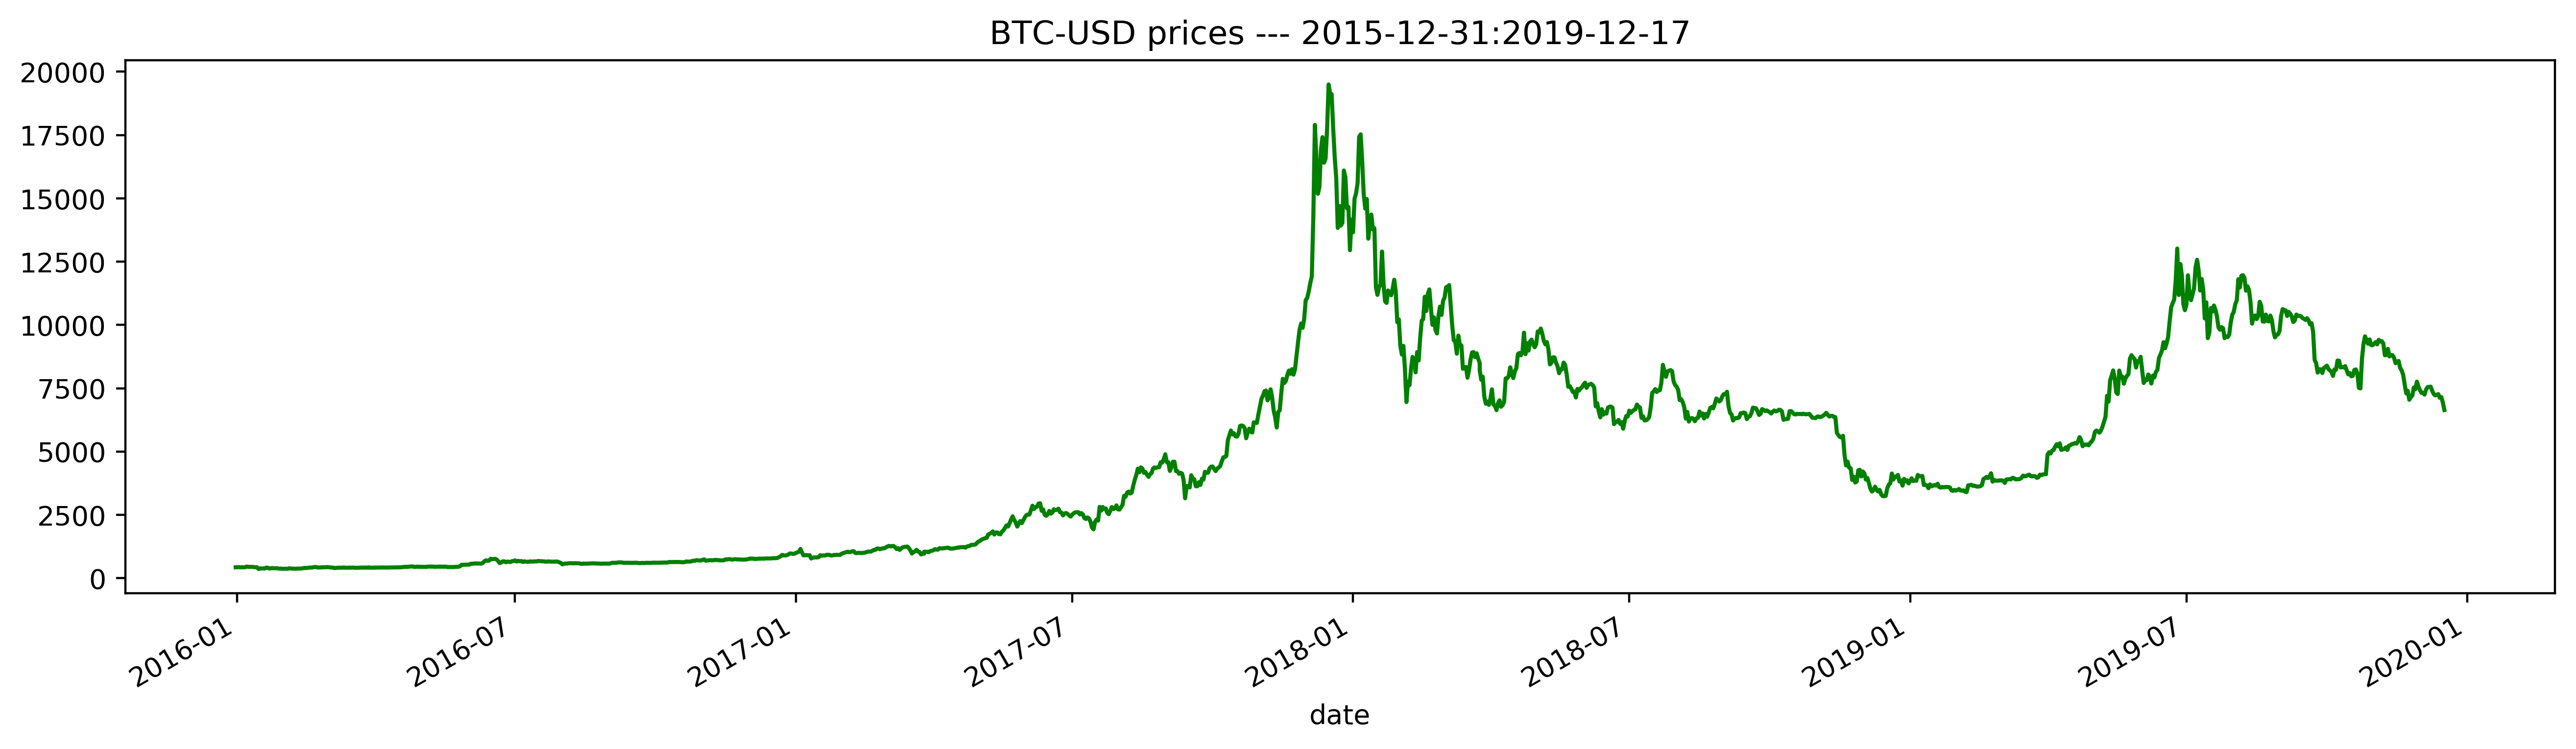

In [85]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-17', 
                  freq='daily', 
                  path='data/BTC.csv')

In [86]:
RETURN = []

# Симуляция с 1% BTC

In [87]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [88]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].tail())

                 open      close   adjclose
date                                       
2019-12-12  17.250000  17.250000  16.707991
2019-12-13  17.309999  17.309999  16.766106
2019-12-14  17.309999  17.309999  16.766106
2019-12-15  17.309999  17.309999  16.766106
2019-12-16  17.379999  17.379999  16.833906
                   open        close     adjclose
date                                             
2019-12-13  7244.662109  7269.684570  7269.684570
2019-12-14  7268.902832  7124.673828  7124.673828
2019-12-15  7124.239746  7152.301758  7152.301758
2019-12-16  7153.663086  6932.480469  6932.480469
2019-12-17  6931.315430  6640.515137  6640.515137


In [89]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-12  16.707991  16.707991
2019-12-13  16.766106  16.766106
2019-12-14  16.766106  16.766106
2019-12-15  16.766106  16.766106
2019-12-16  16.833906  16.833906
                   open        close
date                                
2019-12-13  7269.684570  7269.684570
2019-12-14  7124.673828  7124.673828
2019-12-15  7152.301758  7152.301758
2019-12-16  6932.480469  6932.480469
2019-12-17  6640.515137  6640.515137


In [90]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1448 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-17 00:00:00+00:00
Minor_axis axis: open to close


In [91]:
WEIGHTS = [0.99, 0.01]
COMMISSION = 0.0007

In [92]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 1000000
    context.time = 0

In [93]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [94]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 17, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [95]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [96]:
#pf.create_simple_tear_sheet(returns, positions, transactions, live_start_date='2018-01-01')

In [97]:
#pf.create_full_tear_sheet(returns)

In [98]:
qf.get_performance_summary(returns)

annual_volatility     0.111471
annualized_returns    0.102218
cumulative_returns    0.470823
max_drawdown         -0.265934
sharpe_ratio          0.928941
sortino_ratio         1.342598
dtype: float64

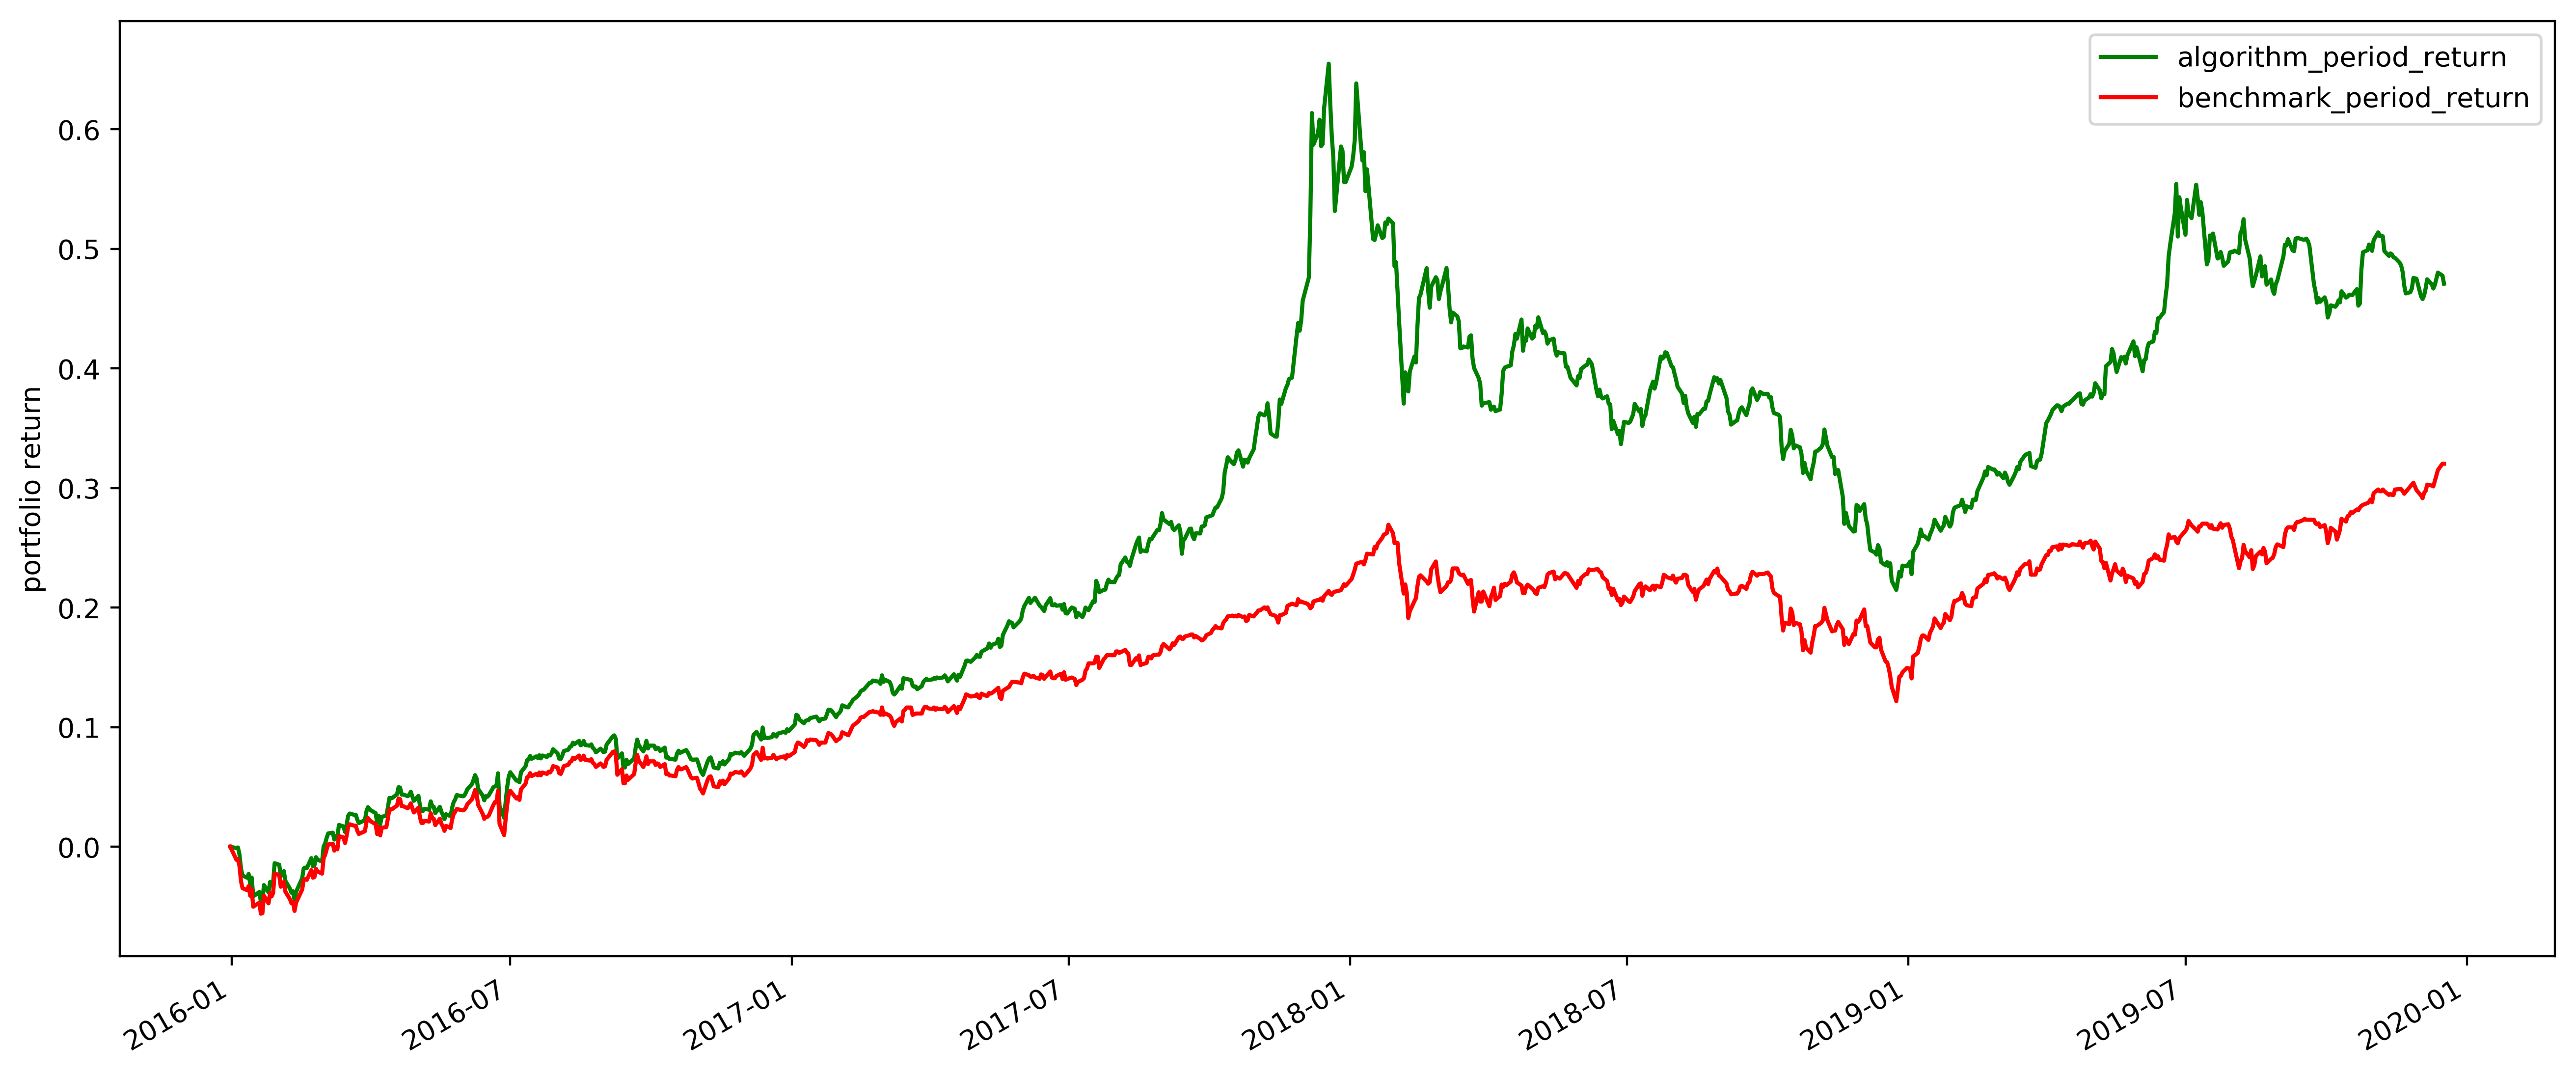

Final portfolio return: 47.08%
Final benchmark return: 32.03%


In [99]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [100]:
(perf.portfolio_value/100000).tail()

2019-12-11 00:00:00+00:00    146.991702
2019-12-12 00:00:00+00:00    147.502602
2019-12-13 00:00:00+00:00    148.015458
2019-12-16 00:00:00+00:00    147.759611
2019-12-17 00:00:00+00:00    147.082252
Name: portfolio_value, dtype: float64

In [101]:
bitcoin1 = perf.algorithm_period_return

In [102]:
RETURN.append(np.round(bitcoin1[-1] * 100, 2))

In [103]:
RETURN

[47.08]

In [104]:
bitcoinPortfolio = 1000 * (1 + bitcoin1)

bitcoinPortfolio = bitcoinPortfolio.rename('Bitcoin 1% Target') 

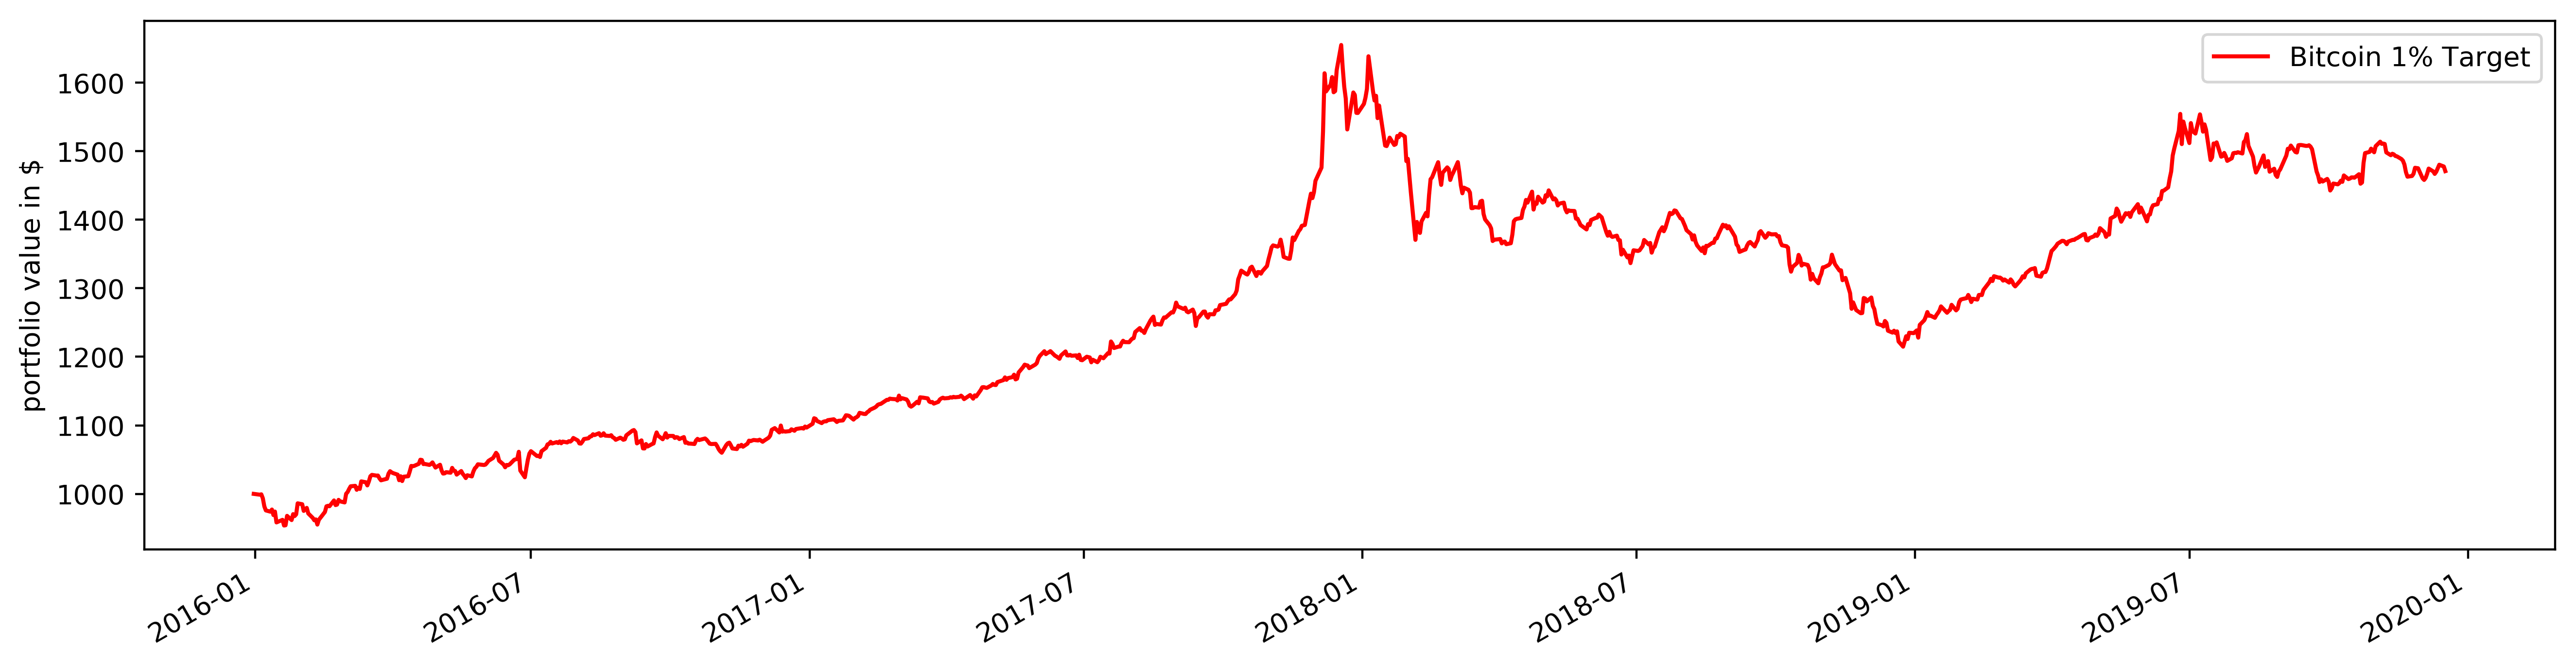

Bitcoin 1%: 47.08%


In [105]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio.plot(color='r')
#portfolio1.plot(color='gold')
#vanguard.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

print('Bitcoin 1%: {}%'.format(RETURN[0]))

In [106]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

Equity(0 [VPGDX])  Equity(1 [BTC])          cash
2016-01-04       9.791451e+06    100477.112793  96198.516056
2016-01-05       9.797166e+06    100214.718018  96198.516056
2016-01-06       9.740039e+06     99552.362549  96198.516056
2016-01-07       9.614361e+06    106267.136963  96198.516056
2016-01-08       9.557236e+06    105149.362549  96198.516056

In [108]:
# Поправляем названия столбцов

weights_df.columns = ['VPGDX', 'BTC', 'Cash']

In [109]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])

In [110]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [111]:
norm_weights_df.tail()

VPGDX       BTC      Cash
2019-12-11  0.879541  0.113914  0.006544
2019-12-12  0.879554  0.113924  0.006522
2019-12-13  0.879555  0.113945  0.006499
2019-12-16  0.884641  0.108848  0.006510
2019-12-17  0.888715  0.104744  0.006540

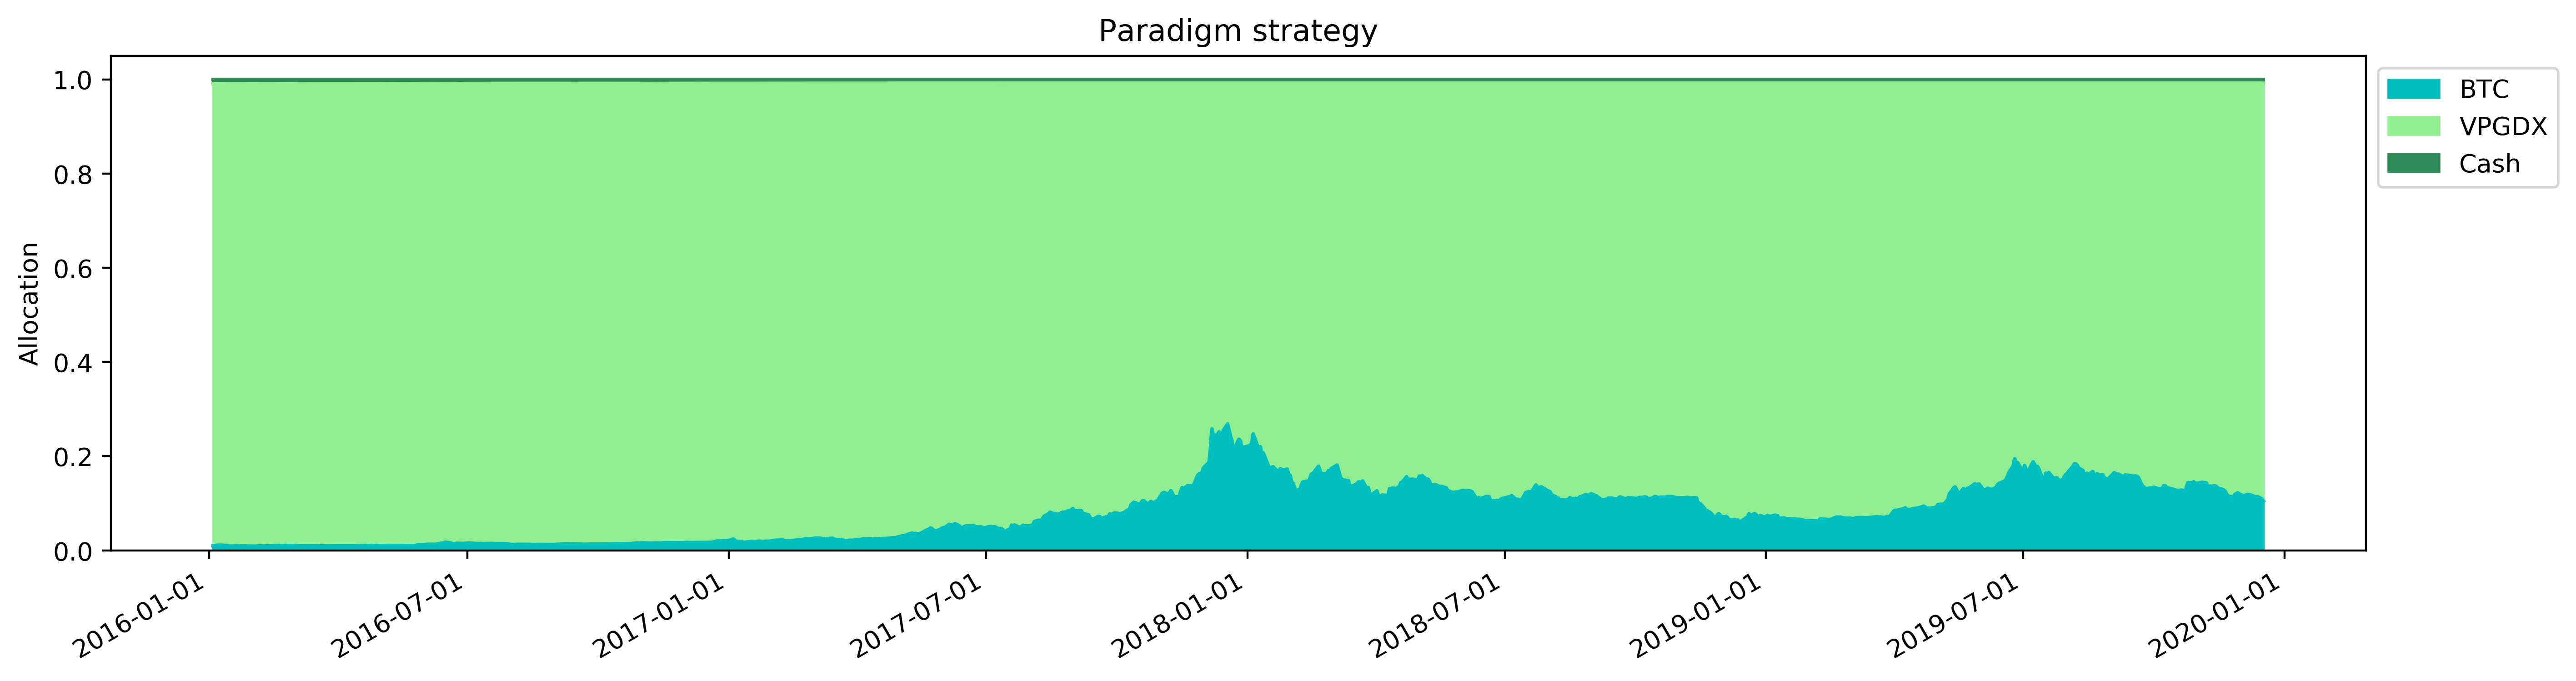

In [112]:
norm_weights_df = norm_weights_df[['BTC', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Симуляция с 1% Paradigm

In [113]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [114]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-12-31  17.330000  17.330000  12.749606
2016-01-01  17.330000  17.330000  12.749606
2016-01-02  17.330000  17.330000  12.749606
2016-01-03  17.330000  17.330000  12.749606
2016-01-04  17.139999  17.139999  12.609821
                  open       close    adjclose
date                                          
2015-12-31  425.875000  430.566986  430.566986
2016-01-01  430.721008  434.334015  434.334015
2016-01-02  434.622009  433.437988  433.437988
2016-01-03  433.578003  430.010986  430.010986
2016-01-04  430.061005  433.091003  433.091003


In [115]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-12  16.707991  16.707991
2019-12-13  16.766106  16.766106
2019-12-14  16.766106  16.766106
2019-12-15  16.766106  16.766106
2019-12-16  16.833906  16.833906
                   open        close
date                                
2019-12-13  7269.684570  7269.684570
2019-12-14  7124.673828  7124.673828
2019-12-15  7152.301758  7152.301758
2019-12-16  6932.480469  6932.480469
2019-12-17  6640.515137  6640.515137


In [116]:
data['BTC']['close'] = paradigm.close.values
data['BTC']['open'] = paradigm.close.values

ValueError: Length of values does not match length of index

In [117]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1448 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-17 00:00:00+00:00
Minor_axis axis: open to close


In [59]:
WEIGHTS = [0.99, 0.01]
COMMISSION = 0.0007

In [60]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 1000000
    context.time = 0

In [61]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [62]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 17, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [63]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [125]:
#pf.create_simple_tear_sheet(returns, positions, transactions, live_start_date='2018-01-01')

In [124]:
#pf.create_full_tear_sheet(returns)

In [66]:
qf.get_performance_summary(returns)

annual_volatility     0.126571
annualized_returns    0.119876
cumulative_returns    0.565769
max_drawdown         -0.284741
sharpe_ratio          0.958067
sortino_ratio         1.357629
dtype: float64

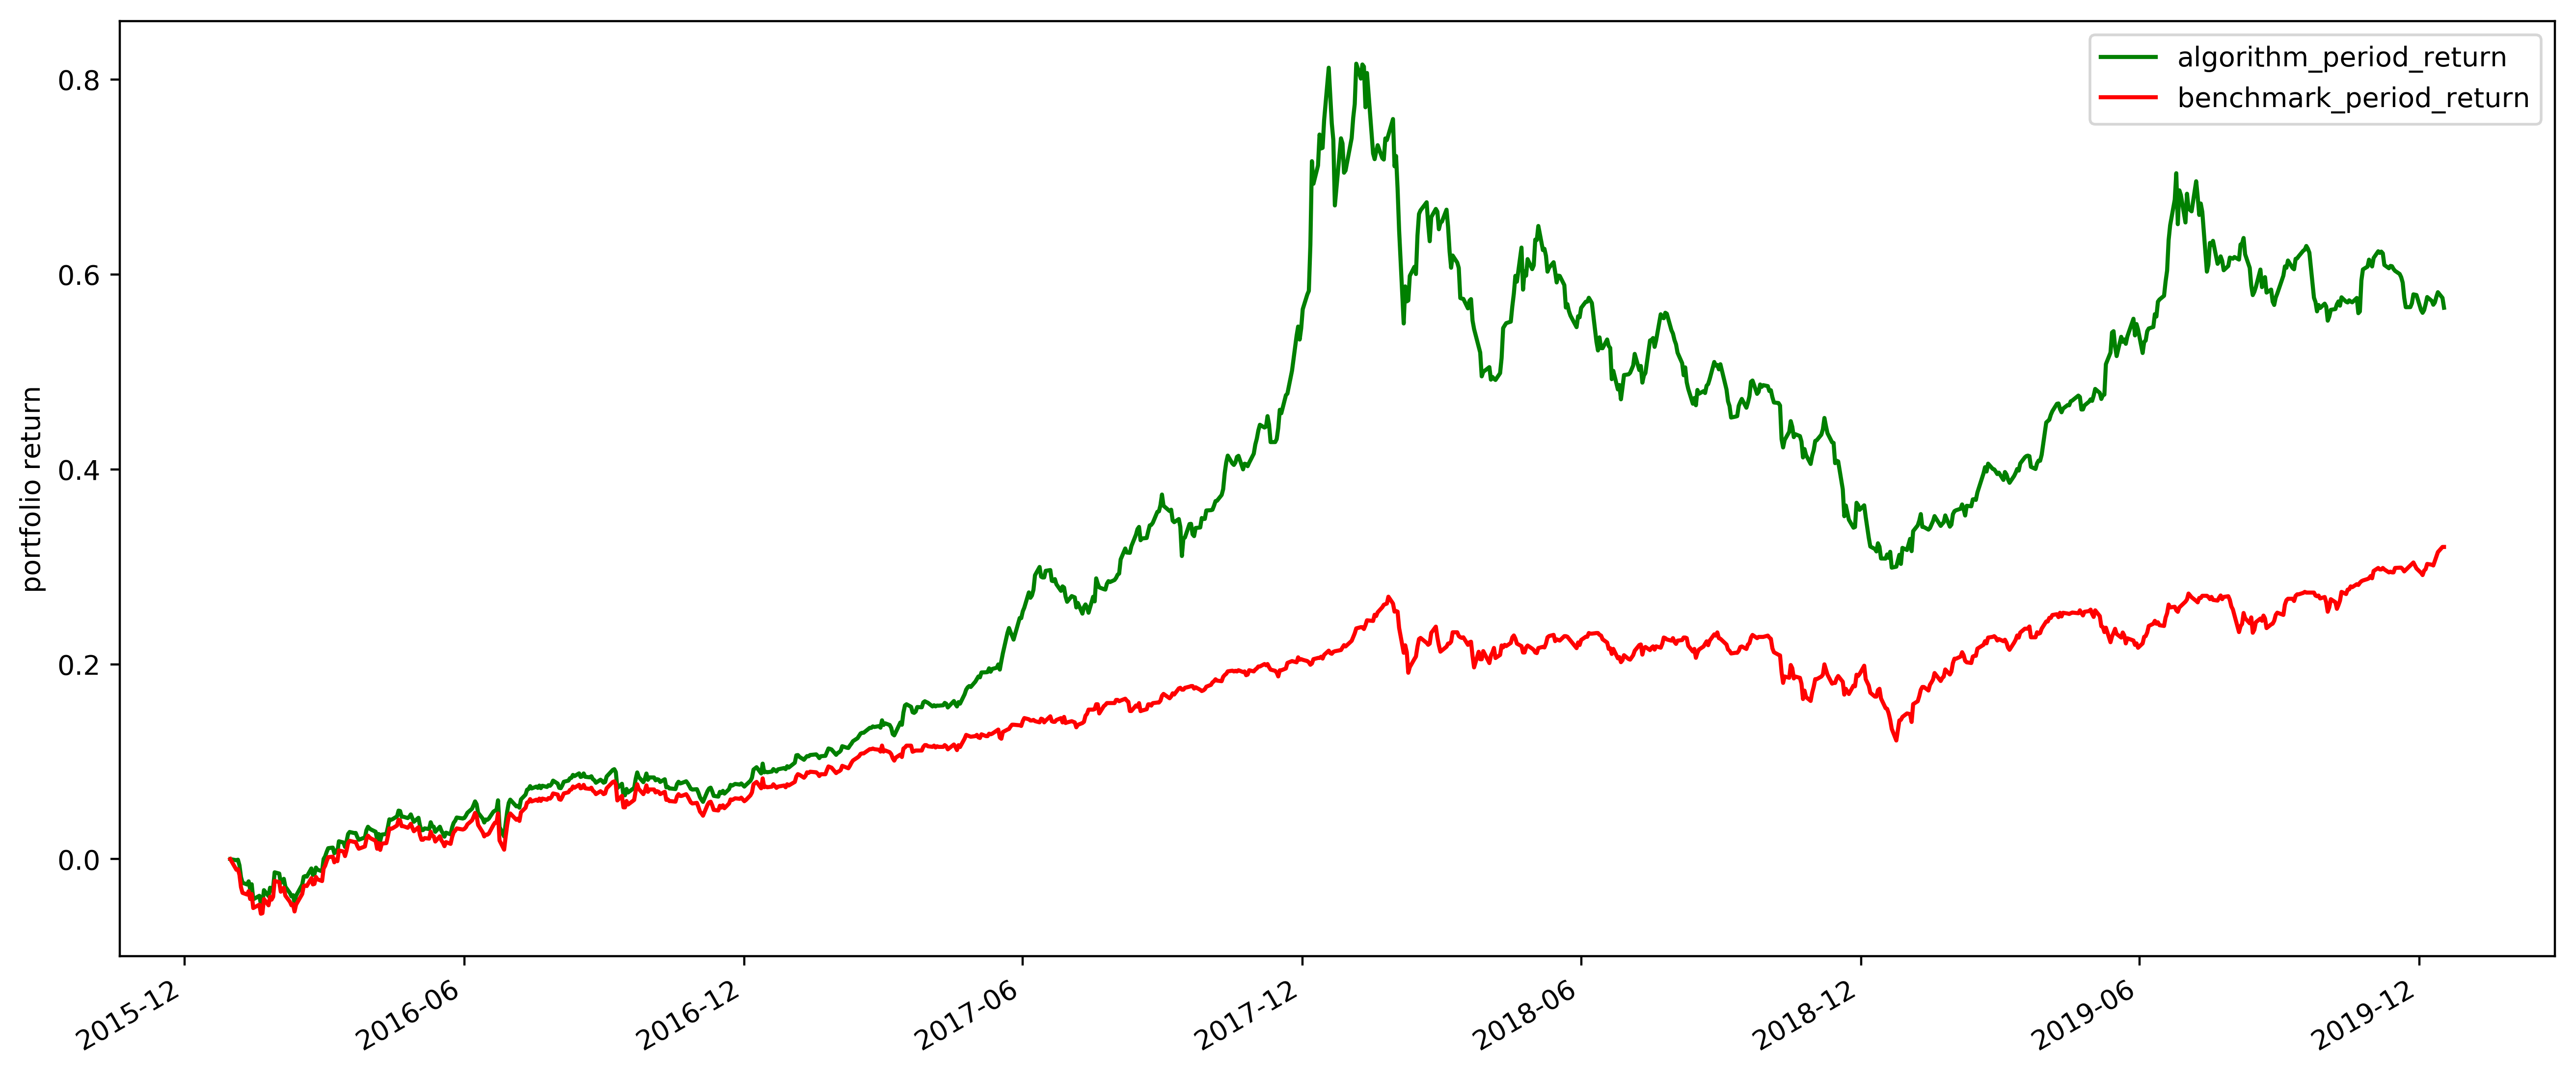

Final portfolio return: 56.58%
Final benchmark return: 32.03%


In [67]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [68]:
paradigm1 = perf.algorithm_period_return

In [69]:
vanguard = perf.benchmark_period_return

In [70]:
RETURN.append(np.round(paradigm1[-1] * 100, 2))
RETURN.append(np.round(vanguard[-1] * 100, 2))

In [71]:
paradigmPortfolio = 1000 * (1 + paradigm1)
benchmark = 1000 * (1 + vanguard)

paradigmPortfolio = paradigmPortfolio.rename('Paradigm 1% Target')
benchmark = benchmark.rename('VPGDX') 

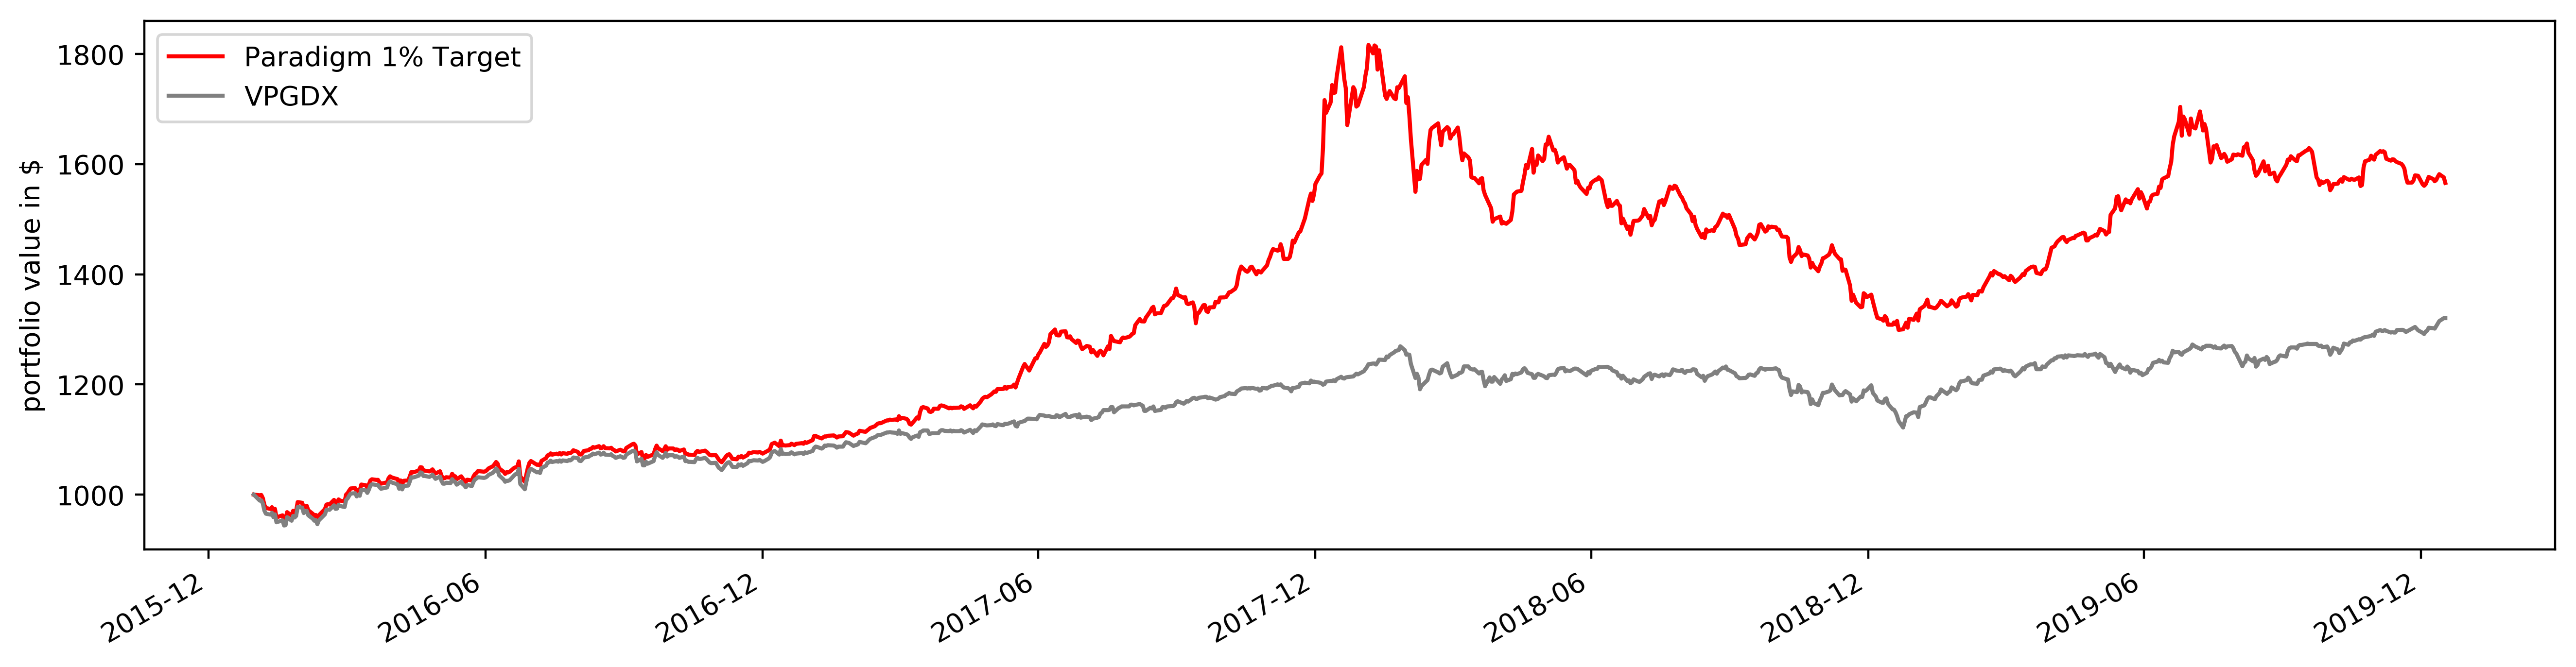

Paradigm 1%: 56.58%
VPGDX: 32.03%


In [72]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
paradigmPortfolio.plot(color='r')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

print('Paradigm 1%: {}%'.format(RETURN[1]))
print('VPGDX: {}%'.format(RETURN[2]))

In [73]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

sid         Equity(0 [VPGDX])  Equity(1 [BTC])          cash
2019-12-11       1.292852e+07     2.685921e+06  97005.935917
2019-12-12       1.297365e+07     2.699010e+06  97005.935917
2019-12-13       1.301878e+07     2.701425e+06  97005.935917
2019-12-16       1.307142e+07     2.590342e+06  97005.935917
2019-12-17       1.307142e+07     2.489266e+06  97005.935917

In [74]:
# Поправляем названия столбцов

weights_df.columns = ['Paradigm', 'VPGDX', 'Cash']

In [75]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['Paradigm'] = weights_df['Paradigm']/(weights_df['Paradigm'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['Paradigm'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['Paradigm'] + weights_df['Cash'])

In [76]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [77]:
norm_weights_df.tail()

Paradigm     VPGDX      Cash
2019-12-11  0.822873  0.170953  0.006174
2019-12-12  0.822697  0.171152  0.006151
2019-12-13  0.823077  0.170790  0.006133
2019-12-16  0.829470  0.164375  0.006156
2019-12-17  0.834824  0.158980  0.006195

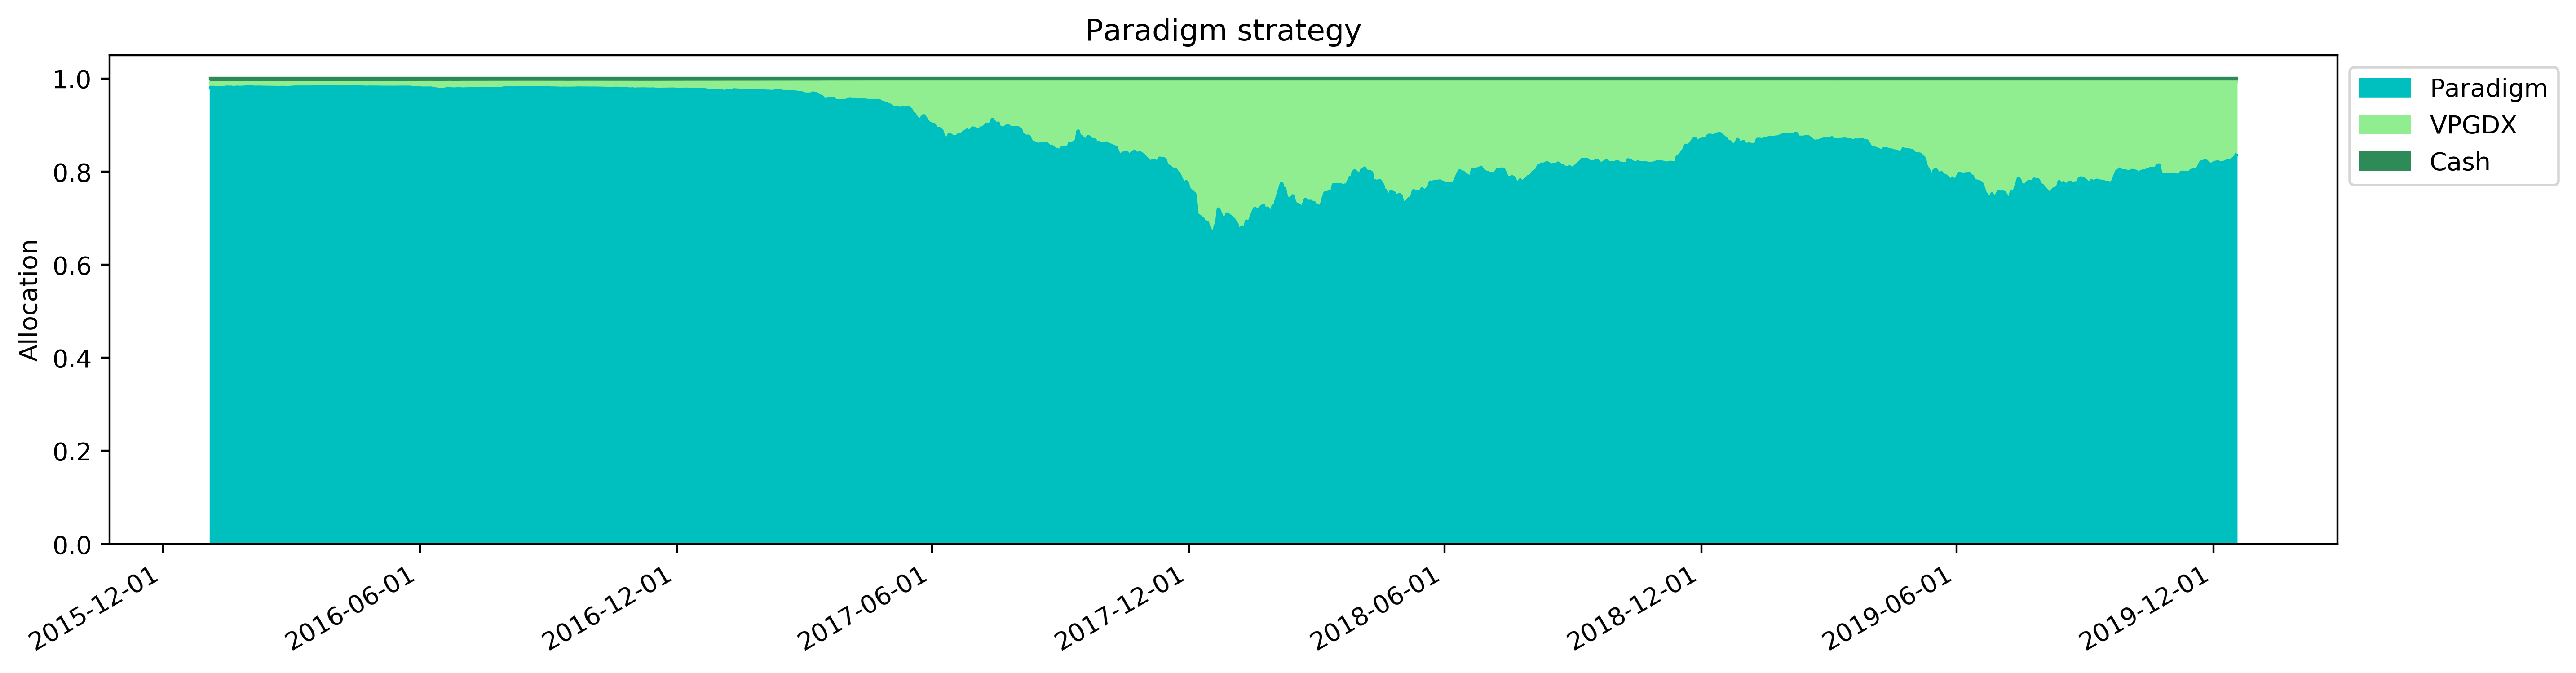

In [78]:
norm_weights_df = norm_weights_df[['Paradigm', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

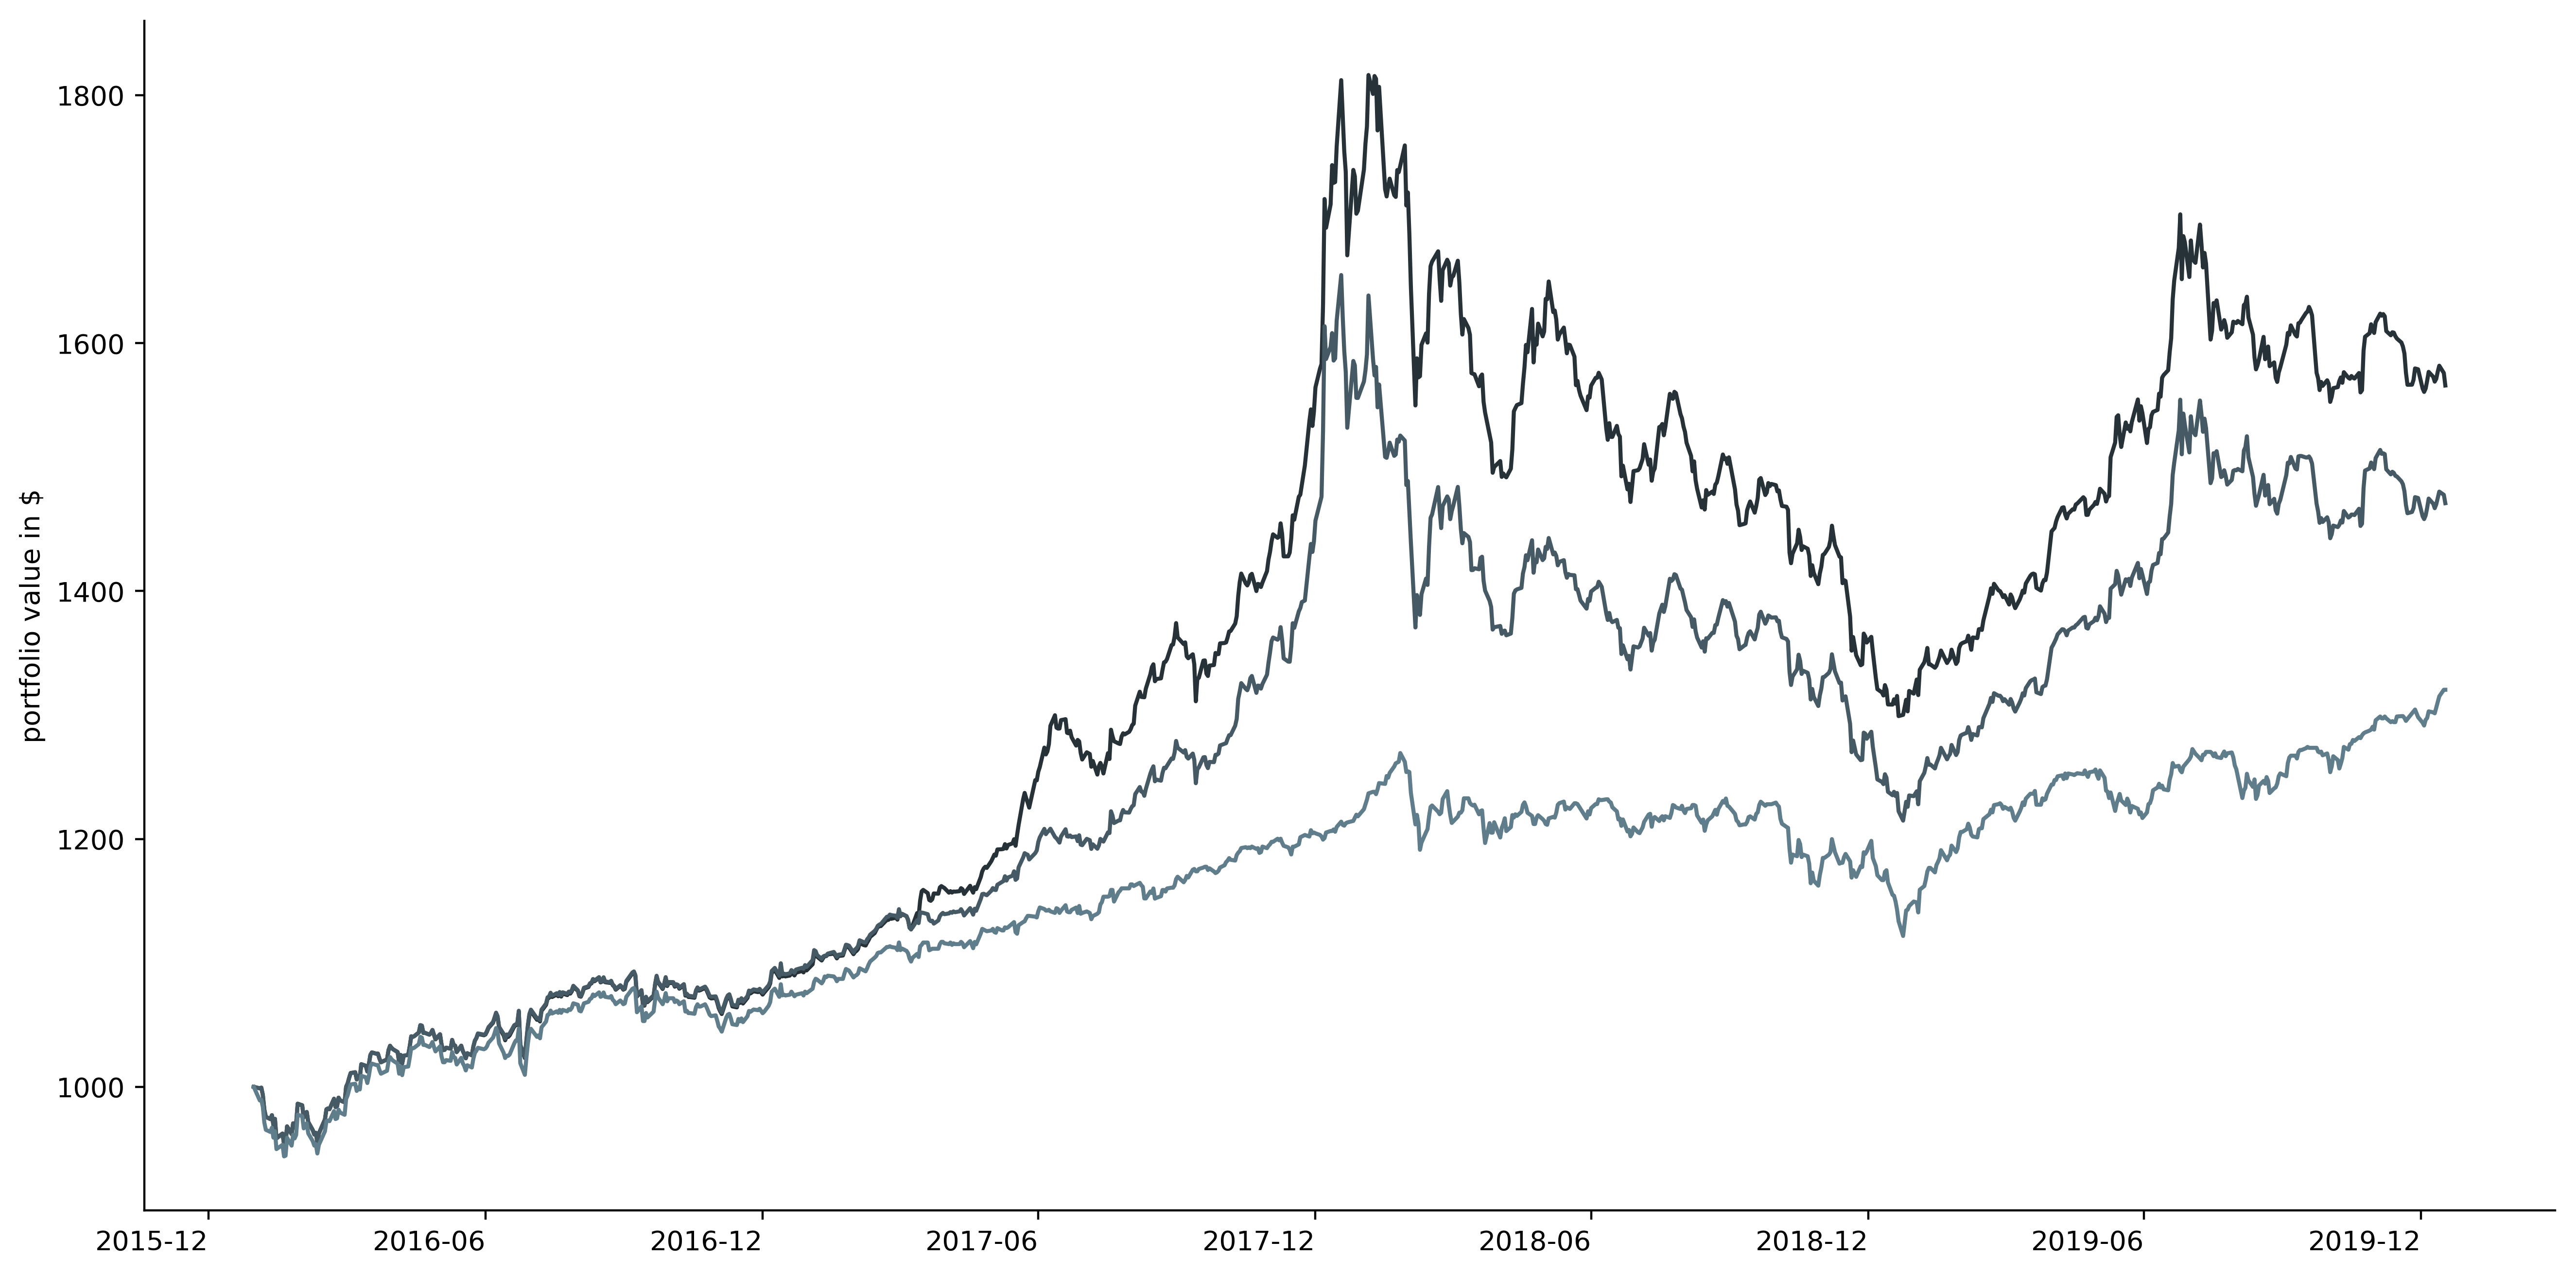

Bitcoin 1%: 47.08%
Paradigm 1%: 56.58%
VPGDX: 32.03%


In [79]:
fig, ax = plt.subplots(figsize=[16, 9])

# portfolio value
paradigmPortfolio.plot(color='#263238')
bitcoinPortfolio.plot(color='#455A64')
benchmark.plot(color='#607D8B')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(rotation='horizontal')

ax.set_ylabel('portfolio value in $')
#plt.legend(edgecolor = 'w')
plt.show()

print('Bitcoin 1%: {}%'.format(RETURN[0]))
print('Paradigm 1%: {}%'.format(RETURN[1]))
print('VPGDX: {}%'.format(RETURN[2]))

In [175]:
#fig.savefig('stats.png', transparent=True, dpi=1000, bbox_inches="tight")

# Bitcoin 0.5%

In [393]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'high', 'low', 'close']

In [193]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open       high        low      close
date                                                  
2015-12-31  17.330000  17.330000  17.330000  17.330000
2016-01-01  17.330000  17.330000  17.330000  17.330000
2016-01-02  17.330000  17.330000  17.330000  17.330000
2016-01-03  17.330000  17.330000  17.330000  17.330000
2016-01-04  17.139999  17.139999  17.139999  17.139999
                  open        high         low       close
date                                                      
2015-12-31  425.875000  432.920990  418.734985  430.566986
2016-01-01  430.721008  436.246002  427.515015  434.334015
2016-01-02  434.622009  436.062012  431.869995  433.437988
2016-01-03  433.578003  433.743011  424.705994  430.010986
2016-01-04  430.061005  434.516998  429.084015  433.091003


In [194]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1437 (major_axis) x 4 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-06 00:00:00+00:00
Minor_axis axis: open to close


In [195]:
WEIGHTS = [0.995, 0.005]
COMMISSION = 0.0007

In [196]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 1000000
    context.time = 0

In [197]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [198]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 6, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [199]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [200]:
qf.get_performance_summary(returns)

annual_volatility     0.097208
annualized_returns    0.019236
cumulative_returns    0.077889
max_drawdown         -0.285250
sharpe_ratio          0.245218
sortino_ratio         0.314484
dtype: float64

In [201]:
bitcoin05 = perf.algorithm_period_return

In [202]:
bitcoinPortfolio05 = 1000 * (1 + bitcoin05)

bitcoinPortfolio05 = bitcoinPortfolio05.rename('Bitcoin 0.5% Target') 

# 0.5% Paradigm

In [203]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close']

In [204]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close
date                            
2015-12-31  17.330000  17.330000
2016-01-01  17.330000  17.330000
2016-01-02  17.330000  17.330000
2016-01-03  17.330000  17.330000
2016-01-04  17.139999  17.139999
                  open       close
date                              
2015-12-31  425.875000  430.566986
2016-01-01  430.721008  434.334015
2016-01-02  434.622009  433.437988
2016-01-03  433.578003  430.010986
2016-01-04  430.061005  433.091003


In [205]:
data['BTC']['close'] = paradigm.close.values
data['BTC']['open'] = paradigm.close.values

In [206]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1437 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-06 00:00:00+00:00
Minor_axis axis: open to close


In [207]:
WEIGHTS = [0.995, 0.005]
COMMISSION = 0.0007

In [208]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 1000000
    context.time = 0

In [209]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [210]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 6, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [211]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [212]:
qf.get_performance_summary(returns)

annual_volatility     0.103741
annualized_returns    0.031300
cumulative_returns    0.128989
max_drawdown         -0.299093
sharpe_ratio          0.349469
sortino_ratio         0.453459
dtype: float64

In [213]:
paradigm05 = perf.algorithm_period_return

In [214]:
paradigmPortfolio05 = 1000 * (1 + paradigm05)
paradigmPortfolio05 = paradigmPortfolio05.rename('Paradigm 0.5% Target')

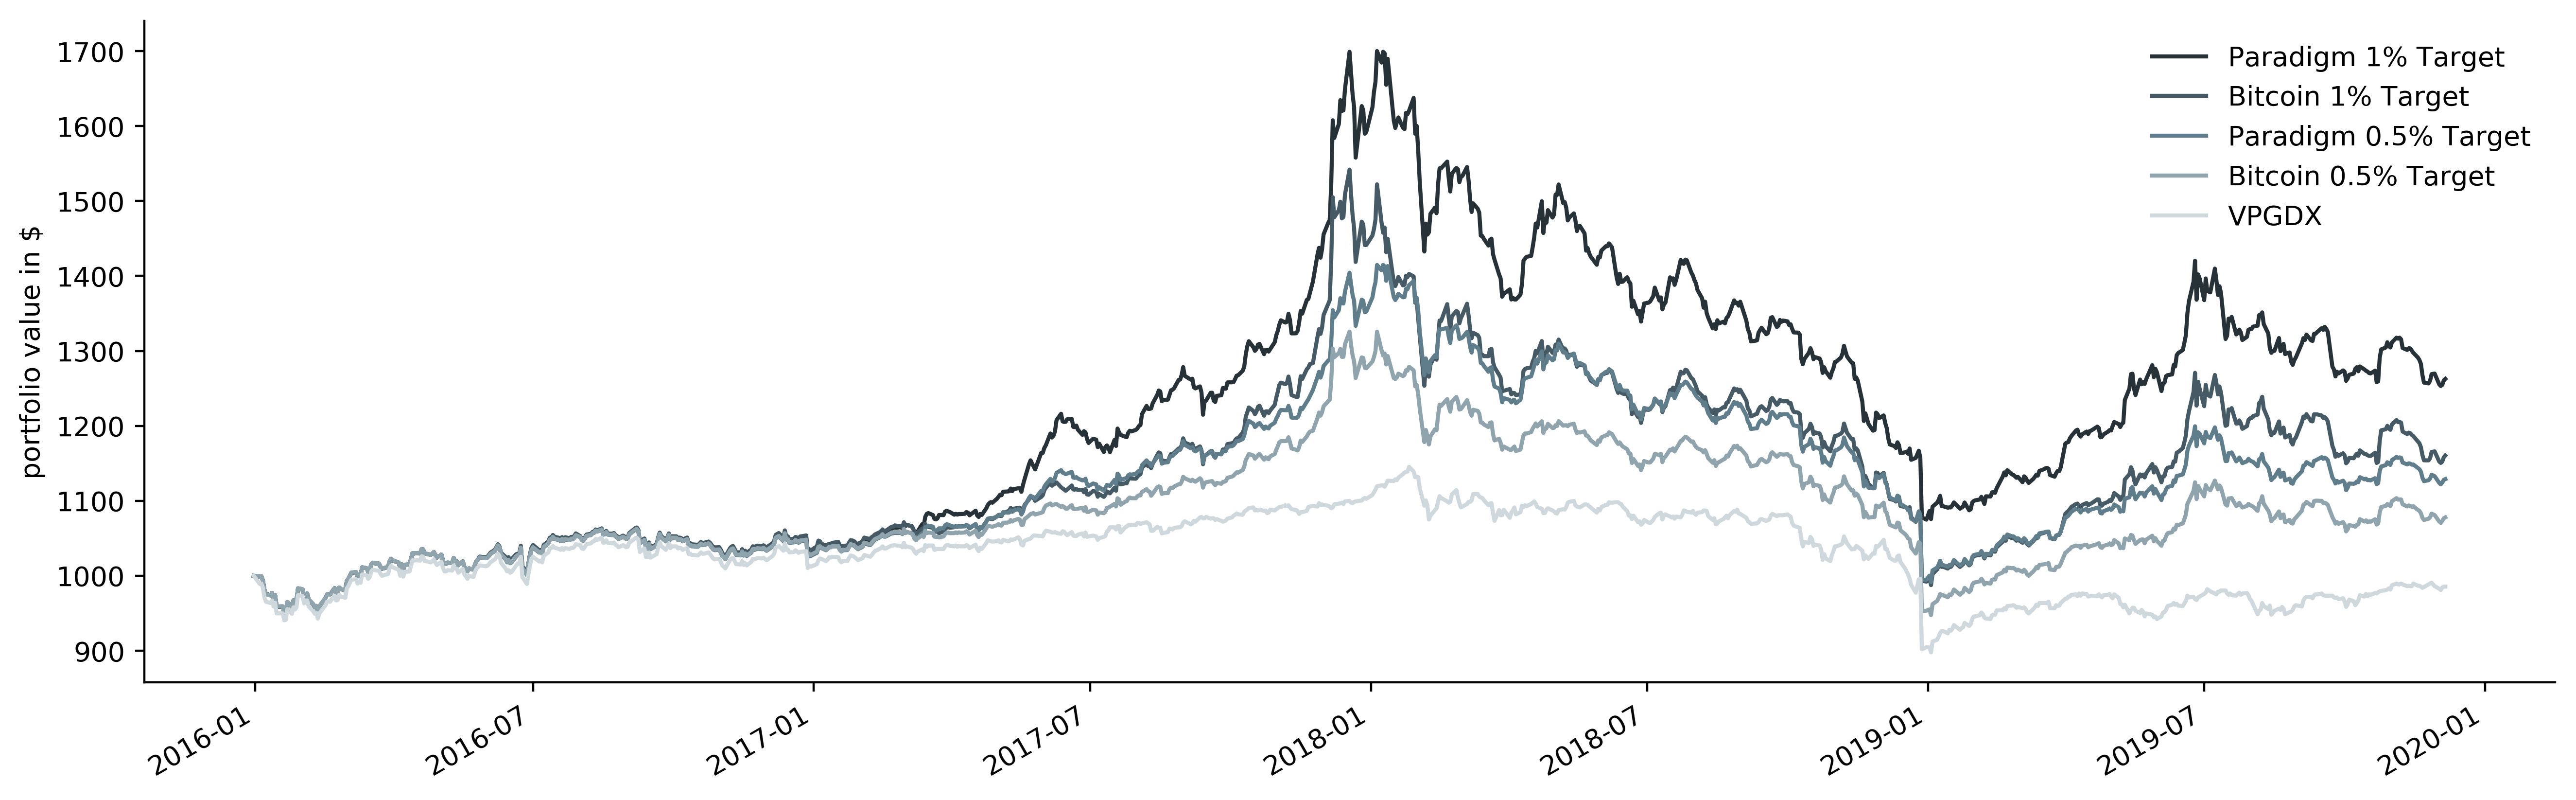

In [215]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
paradigmPortfolio.plot(color='#263238')
bitcoinPortfolio.plot(color='#455A64')
paradigmPortfolio05.plot(color='#607D8B')
bitcoinPortfolio05.plot(color='#90A4AE')
benchmark.plot(color='#CFD8DC')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('portfolio value in $')

# https://pyprog.pro/mpl/mpl_adding_a_legend.html
plt.legend(edgecolor = 'w')     
plt.show()

In [216]:
#fig.savefig('stats5.png', transparent=True, dpi=1000, bbox_inches="tight")

# Просадки

In [217]:
window = 365

In [218]:
# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 365 days data have an expanding window
Roll_Max1 = pd.rolling_max(paradigmPortfolio, window, min_periods=1)
Roll_Max2 = pd.rolling_max(bitcoinPortfolio, window, min_periods=1)
Daily_Drawdown1 = paradigmPortfolio/Roll_Max1 - 1.0
Daily_Drawdown2 = bitcoinPortfolio/Roll_Max2 - 1.0

In [219]:
# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown1 = pd.rolling_min(Daily_Drawdown1, window, min_periods=1)
Max_Daily_Drawdown2 = pd.rolling_min(Daily_Drawdown2, window, min_periods=1)

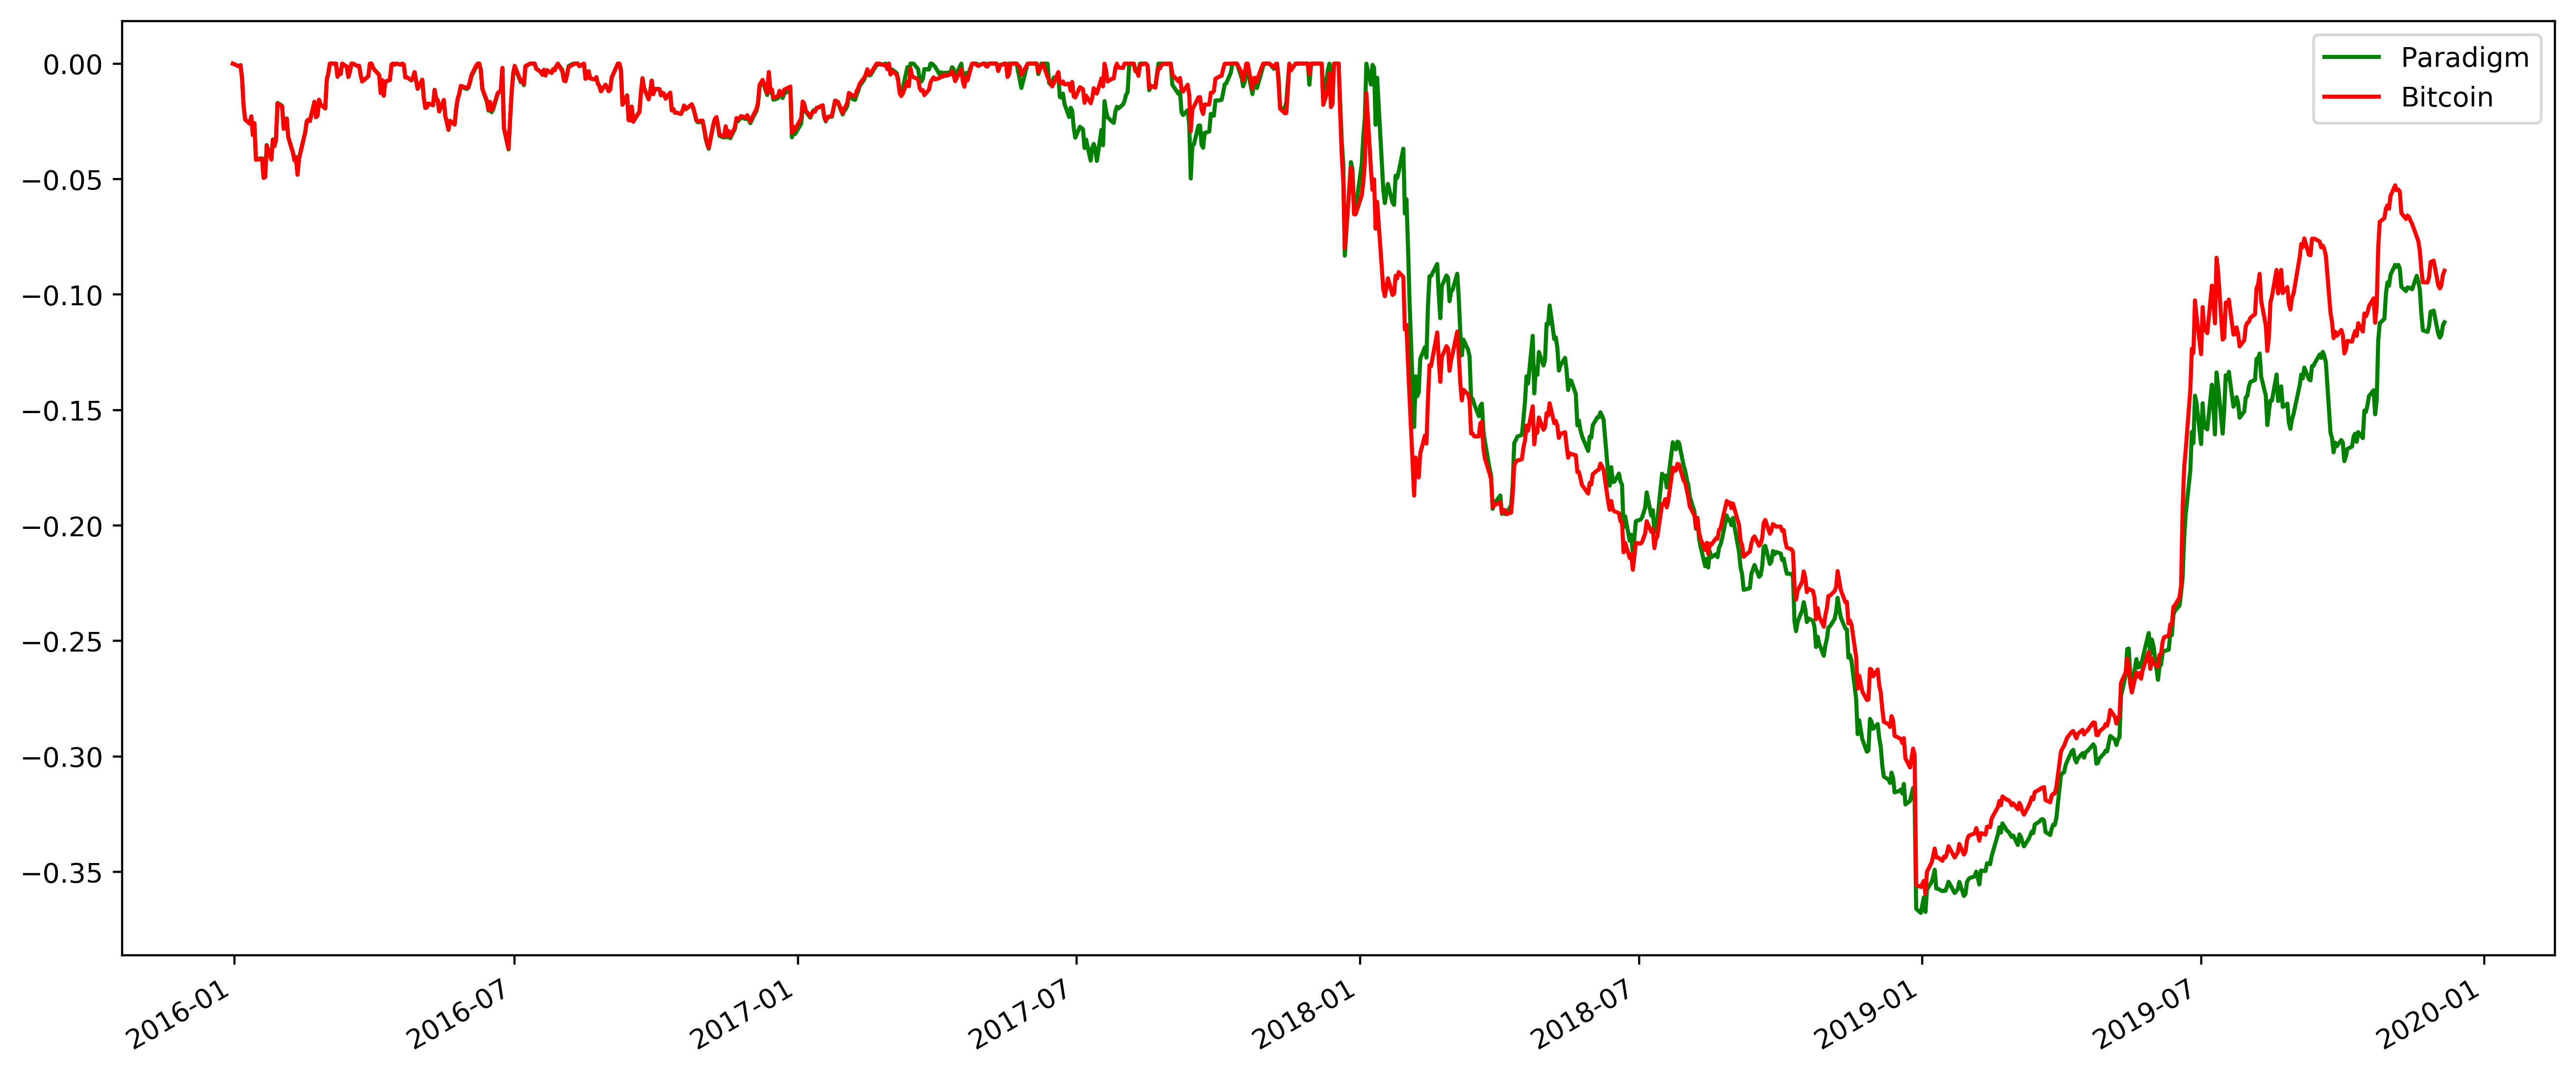

In [220]:
# Plot the results
fig, ax = plt.subplots(figsize=[16, 7])
Daily_Drawdown1.plot(color='g', label='Paradigm')
Daily_Drawdown2.plot(color='r', label='Bitcoin')
plt.legend()
plt.show()

# Просто фонд Vanguard

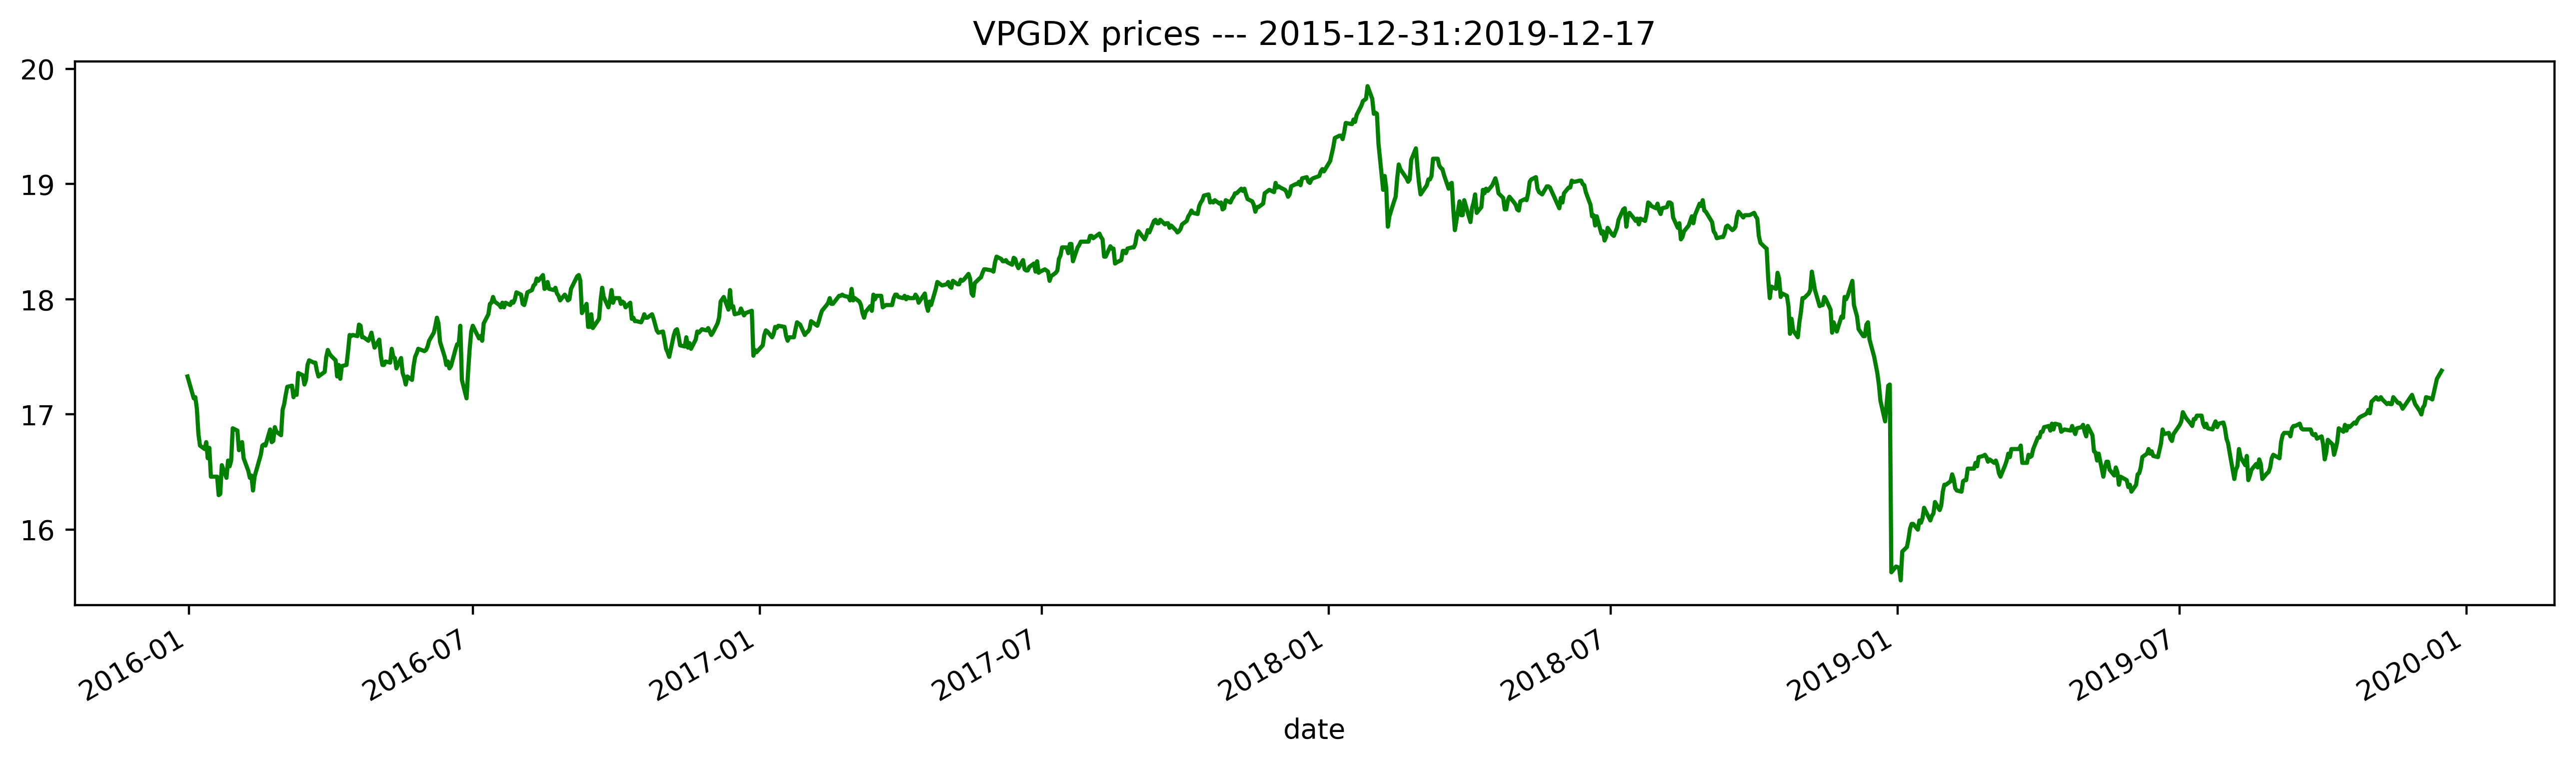

In [449]:
download_csv_data(ticker='VPGDX', 
                  start_date='2015-12-31', 
                  end_date='2019-12-17', 
                  freq='daily', 
                  path='data/VPGDX.csv')

In [456]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [457]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-12-31  17.330000  17.330000  13.163204
2016-01-01  17.330000  17.330000  13.163204
2016-01-02  17.330000  17.330000  13.163204
2016-01-03  17.330000  17.330000  13.163204
2016-01-04  17.139999  17.139999  13.018887


In [458]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-12-12  17.250000  17.250000
2019-12-13  17.309999  17.309999
2019-12-14  17.309999  17.309999
2019-12-15  17.309999  17.309999
2019-12-16  17.379999  17.379999


In [459]:
WEIGHTS = [1]
COMMISSION = 0.0007

In [460]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    #context.rebalance_period = 1000000
    context.time = 0

In [464]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):  
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [465]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 17, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

ValueError: cannot reindex from a duplicate axis

In [402]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [185]:
qf.get_performance_summary(returns)

annual_volatility     0.067260
annualized_returns    0.073680
cumulative_returns    0.324806
max_drawdown         -0.115337
sharpe_ratio          1.090763
sortino_ratio         1.530601
dtype: float64